# Determining optimal hyperparamter configuration for regional fire activity 

Authors: Jatan Buch (v1, 220111)

## 1 - Packages

In [1]:
import numpy as np
import pandas as pd
#from time import clock
from datetime import date, datetime, timedelta
from cftime import num2date, date2num, DatetimeGregorian
from tqdm import tqdm
from copy import deepcopy

#Import and write files
import csv
import netCDF4 # module that reads in .nc files (built on top of HDF5 format)
import pandas as pd
import geopandas as gpd
from geopandas.tools import sjoin
import xarray
import rioxarray

from shapely.geometry import Point, mapping
from shapely.geometry.polygon import Polygon
from pyproj import CRS, Transformer # for transforming projected coordinates to elliptical coordinates
import cartopy.crs as ccrs # for defining and transforming coordinate systems
import cartopy.feature as cfeature # to add features to a cartopy map
import cartopy.io.shapereader as shpreader

#self-libraries
from fire_utils import *
from ml_utils import *

#Helper functions
from math import factorial
from scipy import stats
from scipy.special import gamma
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.exceptions import NotFittedError
from tensorflow.python import ops
from tensorflow.python import debug as tf_debug

#Plot modules
import matplotlib.pyplot as plt
%matplotlib inline
%config IPython.matplotlib.backend = 'retina'
%config InlineBackend.figure_format = 'retina'

#Stats modules
from scipy import stats
from scipy.stats import norm, pareto, genpareto
import statsmodels.api as sm
from scipy import stats, interpolate
from scipy.optimize import minimize

# Data processing
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split

#modules for Machine Learning
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import LinearRegression

#modules for Neural Network
import tensorflow as tf
import tensorflow_probability as tfp
tfd= tfp.distributions
from tensorflow.keras.layers import Input, Dense, Activation, Concatenate
from tensorflow.keras.callbacks import EarlyStopping, TensorBoard, ReduceLROnPlateau
#import tensorflow.compat.v1 as tf
#tf.disable_v2_behavior()
#from tensorflow.keras import layers
#from tensorflow.python.ops.parallel_for.gradients import jacobian

In [2]:
data_dir= "../data/"
pred_input_path= "12km/"
fire_file= data_dir + "burnarea_12km.nc"

In [3]:
fire_size_train= pd.read_hdf(data_dir + 'clim_fire_size_12km_train_data.h5')
fire_size_test= pd.read_hdf(data_dir + 'clim_fire_size_12km_test_data.h5')

fire_L3_freq_df= pd.read_hdf(data_dir + 'clim_L3_fire_freq_data.h5')
L3_weights, _= np.histogram(fire_L3_freq_df['fire_freq'], density= True, bins= [0, 1, 10, 20, 40, 70, 100]) 
sample_L3_weight_arr= pd.cut(fire_L3_freq_df['fire_freq'].to_numpy(), bins= [0, 1, 10, 20, 40, 70, 100], \
                             labels= (L3_weights[0]/L3_weights)/np.sum(L3_weights[0]/L3_weights), include_lowest= True)
fire_L3_freq_df['sample_weight']= sample_L3_weight_arr

fire_L4_freq_df= pd.read_hdf(data_dir + 'clim_L4_fire_freq_data.h5')
L4_weights, _= np.histogram(fire_L4_freq_df['fire_freq'], density= True, bins= [0, 1, 3, 5, 20, 50]) 
sample_L4_weight_arr= pd.cut(fire_L4_freq_df['fire_freq'].to_numpy(), bins= [0, 1, 3, 5, 20, 50], 
                            labels= (L4_weights[0]/L4_weights)/np.sum(L4_weights[0]/L4_weights), include_lowest= True)
fire_L4_freq_df['sample_weight']= sample_L4_weight_arr
#fire_freq_L3_data= np.array(fire_freq_df[fire_freq_df['month'] >= 372].fire_freq, dtype=np.float32)

## 2 - Testing

In [4]:
X_L3_freqs_train, X_L3_freqs_val, y_L3_freqs_train, y_L3_freqs_val, fire_L3_freq_test, X_L3_freqs_test, y_L3_freqs_test, L3_freq_samp_weight_arr= fire_freq_data(fire_L3_freq_df)
X_L4_freqs_train, X_L4_freqs_val, y_L4_freqs_train, y_L4_freqs_val, fire_L4_freq_test, X_L4_freqs_test, y_L4_freqs_test, L4_freq_samp_weight_arr= fire_freq_data(fire_L4_freq_df)

### 2.1 Fire frequency

In [5]:
#%time hp_df= fire_freq_predict(fire_L3_freq_df, fire_L4_freq_df, n_iters= 10, n_epochs= 500, bs= 32)
#hp_df.to_hdf('../sav_files/iter_runs_%s/'%date.today().strftime("%y_%m_%d") + 'hyperparams_iter_runs_%s.h5'%date.today().strftime("%y_%m_%d"), key= 'df', mode= 'w')

In [6]:
n_regions= 18
tot_months= 60
month_arr= np.linspace(0, tot_months - 1, tot_months, dtype= int)
year_arr= np.asarray([2015, 2016, 2017, 2018, 2019, 2020]) 

reg_name= {1: "Sierra Nevada", 2: "North Coast", 3: "Central Coast", 4: "South Coast", 5: "Pacific NW", 6: "Columbia Plateau", 7:"Northern Rockies", \
          8: "Middle Rockies", 9: "Southern Rockies", 10: "AM Semidesert", 11: "AZ/NM Mts.", 12: "IM Semidesert", 13: "IM Desert", 14: "Northern Great Plains", \
          15: "High Plains", 16: "CO Plateau", 17: "SW Tablelands", 18: "CH Desert"}
ind_grid_1= [[1, 2, 3], [4, 5, 6], [7, 8, 9]]
ind_grid_2= [[10, 11, 12], [13, 14, 15], [16, 17, 18]]

freqtestgrps= fire_L4_freq_test.groupby('reg_indx')
reglenarr= np.asarray([len(freqtestgrps.get_group(k)) for k in freqtestgrps.groups.keys()])
cumreglen= np.insert(np.cumsum(reglenarr), 0, 0)

freq_test_size= np.int64(len(y_L3_freqs_test)/n_regions)
freq_arr_1= np.linspace(0, len(y_L3_freqs_test) - freq_test_size, n_regions, dtype= int)
freq_arr_2= freq_arr_1 + freq_test_size

In [79]:
hp_df= pd.read_hdf('../sav_files/iter_runs_22_01_13/hyperparams_iter_runs_22_01_13.h5')
hp_df['tot_metric']= hp_df['Pearson_r']*hp_df['Accuracy']
opt_freq_ind= np.asarray([hp_df.groupby('reg_indx').get_group(i+1).dropna().sort_values(by= ['tot_metric'], ascending= False).iloc[[0]].index for i in range(n_regions)]).flatten()

100%|██████████| 3/3 [02:47<00:00, 55.89s/it]


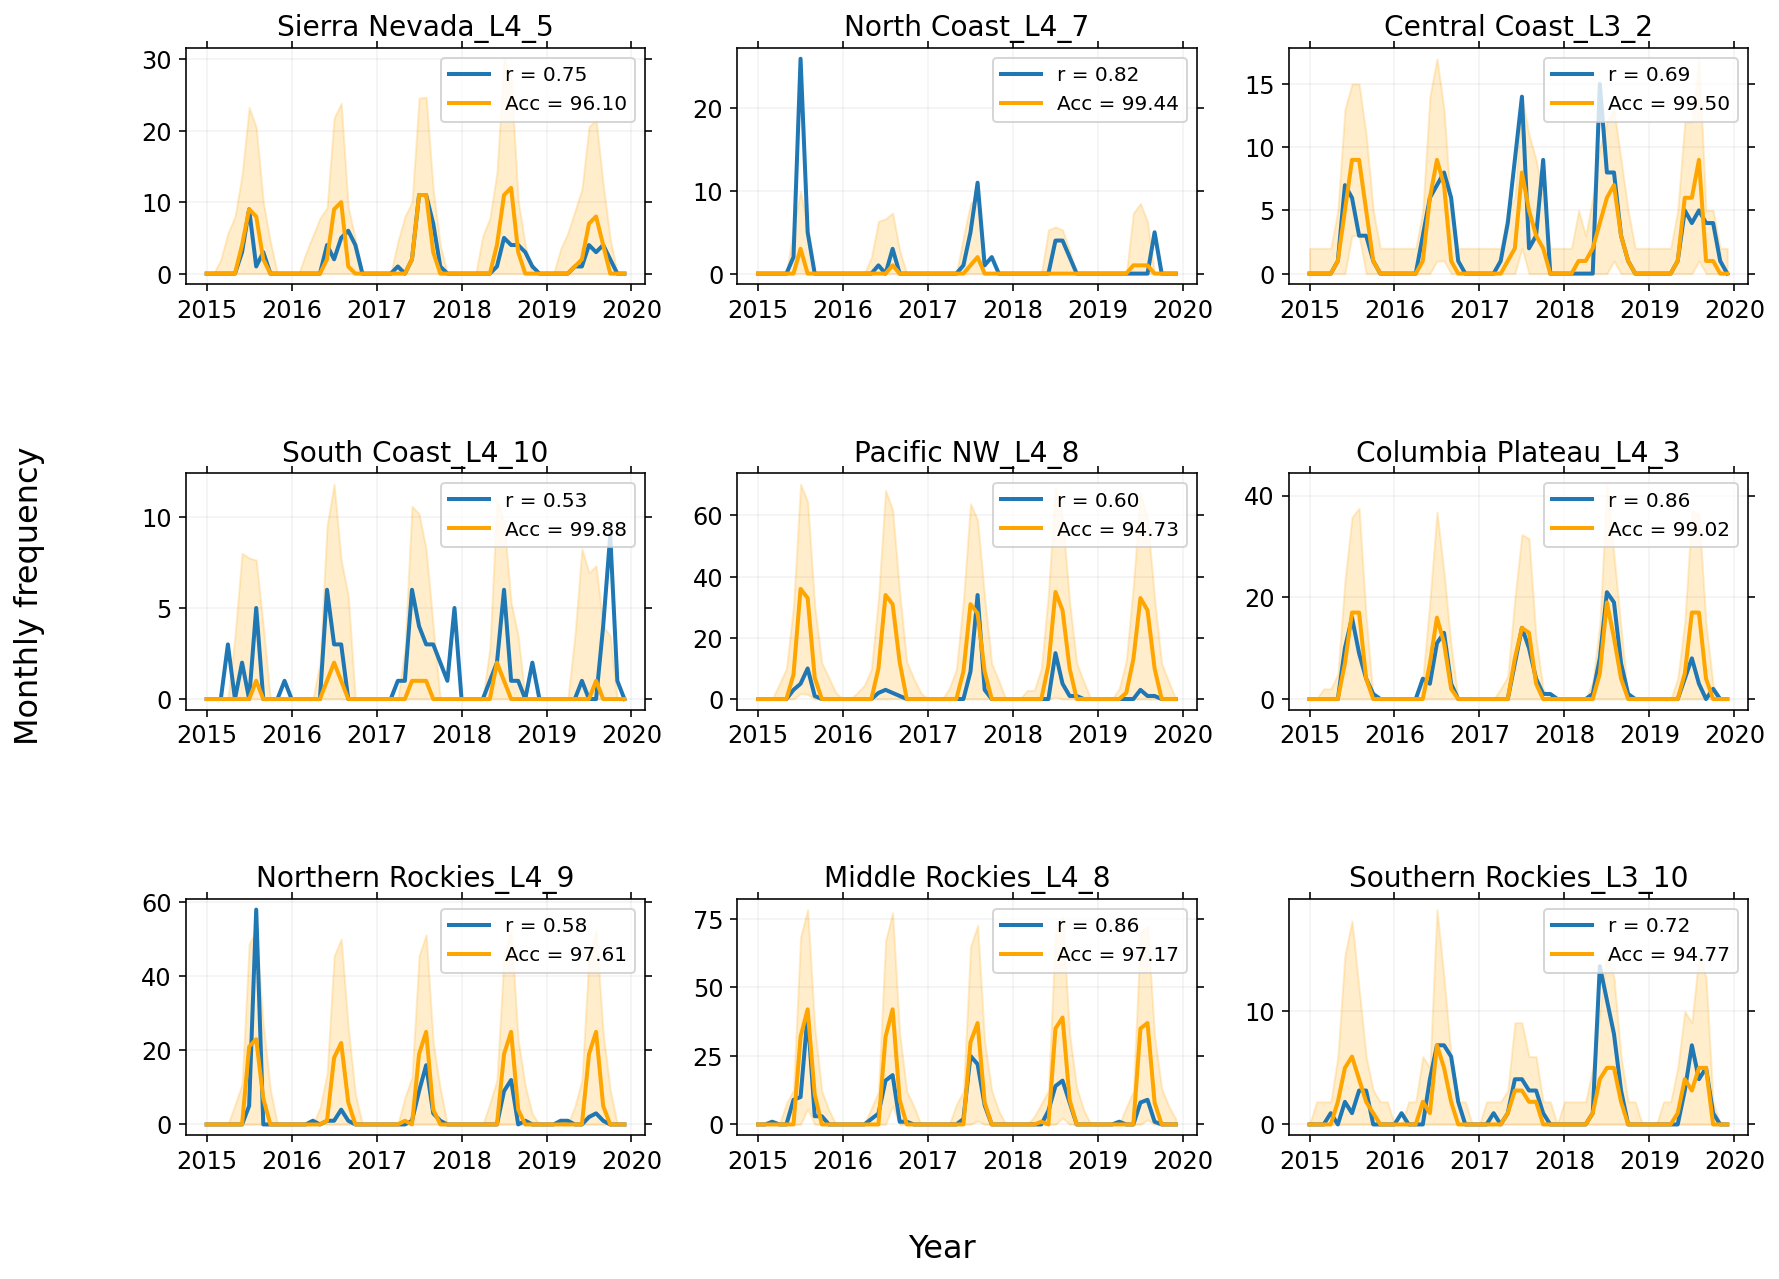

In [80]:
fig, ax= plt.subplots(3, 3, figsize=(14, 10))
#plt.suptitle(r'Monthly fire frequency across regions', fontsize= 18);
fig.text(0.04, 0.5, r'Monthly frequency', va='center', rotation='vertical', fontsize= 16);
fig.text(0.5, 0.04, r'Year', ha='center', fontsize= 16)

for i in tqdm(range(3)):
    for j in range(3):
        regindx= ind_grid_1[i][j]
        mod_params= hp_df.loc[opt_freq_ind[regindx - 1]].to_dict()
        
        if mod_params['reg_flag'] == 'L4':
            if mod_params['func_flag'] == 'zipd':
                mdn_L4_zipd= tf.keras.models.load_model('../sav_files/iter_runs_22_01_13/mdn_L4_zipd_iter_%d'%(mod_params['Iteration']), \
                                                                                    custom_objects= {'zipd_loss': zipd_loss, 'zipd_accuracy': zipd_accuracy})
                reg_L4_freq_df= freq_pred_func(mdn_model= mdn_L4_zipd, X_test_dat= X_L4_freqs_test, func_flag= 'zipd', l4_flag= True, reg_len_arr= reglenarr, modsave= True)
            else:
                mdn_L4_zinb= tf.keras.models.load_model('../sav_files/iter_runs_22_01_13/mdn_L4_zinb_iter_%d'%(mod_params['Iteration']), \
                                                                                    custom_objects= {'zinb_loss': zinb_loss, 'zinb_accuracy': zinb_accuracy})
                reg_L4_freq_df= freq_pred_func(mdn_model= mdn_L4_zinb, X_test_dat= X_L4_freqs_test, func_flag= 'zipd', l4_flag= True, reg_len_arr= reglenarr, modsave= True)

            reg_L4_freq_groups= reg_L4_freq_df.groupby('reg_indx')
            fire_l3_mean_freqs= np.asarray([np.sum(reg_L4_freq_groups.get_group(regindx)['mean_freq'].iloc[np.arange(m, reglenarr[regindx - 1], tot_months)]) \
                                                                                            for m in range(tot_months)])
            fire_l3_high_freqs= fire_l3_mean_freqs + 2*np.sqrt([np.sum(reg_L4_freq_groups.get_group(regindx)['std_freq'].iloc[np.arange(m, reglenarr[regindx - 1], tot_months)]**2) \
                                    for m in range(tot_months)])
            fire_l3_low_freqs= fire_l3_mean_freqs - 2*np.sqrt([np.sum(reg_L4_freq_groups.get_group(regindx)['std_freq'].iloc[np.arange(m, reglenarr[regindx - 1], tot_months)]**2) \
                                    for m in range(tot_months)])
            fire_l3_low_freqs[fire_l3_low_freqs < 0]= 0

            ax[i, j].plot(month_arr, np.asarray([np.sum(y_L4_freqs_test[cumreglen[regindx - 1]:cumreglen[regindx]][np.arange(m, reglenarr[regindx - 1], tot_months)]) \
                                                for m in range(tot_months)]), lw= 2, \
                                                label= 'r = %.2f'%mod_params['Pearson_r']);
            ax[i, j].plot(month_arr, fire_l3_mean_freqs, color= 'orange', lw= 2, \
                   label= 'Acc = %.2f'%mod_params['Accuracy']);
            ax[i, j].fill_between(month_arr, fire_l3_high_freqs, fire_l3_low_freqs, color= 'orange', alpha=0.2);
        else:
            if mod_params['func_flag'] == 'zipd':
                mdn_L3_zipd= tf.keras.models.load_model('../sav_files/iter_runs_22_01_13/mdn_L3_zipd_iter_%d'%(mod_params['Iteration']), \
                                                        custom_objects= {'zipd_loss': zipd_loss, 'zipd_accuracy': zipd_accuracy})
                reg_L3_freq_df= freq_pred_func(mdn_model= mdn_L3_zipd, X_test_dat= X_L3_freqs_test, func_flag= 'zipd', l4_flag= False, modsave= True)
            else:
                mdn_L3_zinb= tf.keras.models.load_model('../sav_files/iter_runs_22_01_13/mdn_L3_zinb_iter_%d'%(mod_params['Iteration']), \
                                                        custom_objects= {'zinb_loss': zinb_loss, 'zinb_accuracy': zinb_accuracy})
                reg_L3_freq_df= freq_pred_func(mdn_model= mdn_L3_zinb, X_test_dat= X_L3_freqs_test, func_flag= 'zinb', l4_flag= False, modsave= True)

            reg_L3_freq_groups= reg_L3_freq_df.groupby('reg_indx')
            ax[i, j].plot(month_arr, y_L3_freqs_test[freq_arr_1[regindx - 1]:freq_arr_2[regindx - 1]], lw= 2, \
                                                label= 'r = %.2f'%mod_params['Pearson_r']);
            ax[i, j].plot(month_arr, reg_L3_freq_groups.get_group(regindx)['mean_freq'], color= 'orange', lw= 2, \
                                                label= 'Acc = %.2f'%mod_params['Accuracy']);
            ax[i, j].fill_between(month_arr, reg_L3_freq_groups.get_group(regindx)['high_2sig_freq'], reg_L3_freq_groups.get_group(regindx)['low_2sig_freq'], \
                                                                                                                                     color= 'orange', alpha=0.2);

        ax[i, j].set_title('%s_'%reg_name[regindx] + '%s_'%mod_params['reg_flag'] + '%s'%mod_params['Iteration'], fontsize= 14);
        ax[i, j].set_xticks((year_arr - 2015)*12);
        ax[i, j].set_xticklabels(year_arr)
        fig.subplots_adjust(hspace= 0.8)
        #fig.minorticks_on()
        ax[i, j].legend(loc='upper right', frameon= True);
        ax[i, j].tick_params(labeltop=False, top=True, labelright=False, right=True, which='both', labelsize= 12);
        ax[i, j].grid(b=True, which='major', color='black', alpha=0.05, linestyle='-');
        ax[i, j].grid(b=True, which='minor', color='black', alpha=0.01, linestyle='-');

100%|██████████| 3/3 [03:57<00:00, 79.17s/it]


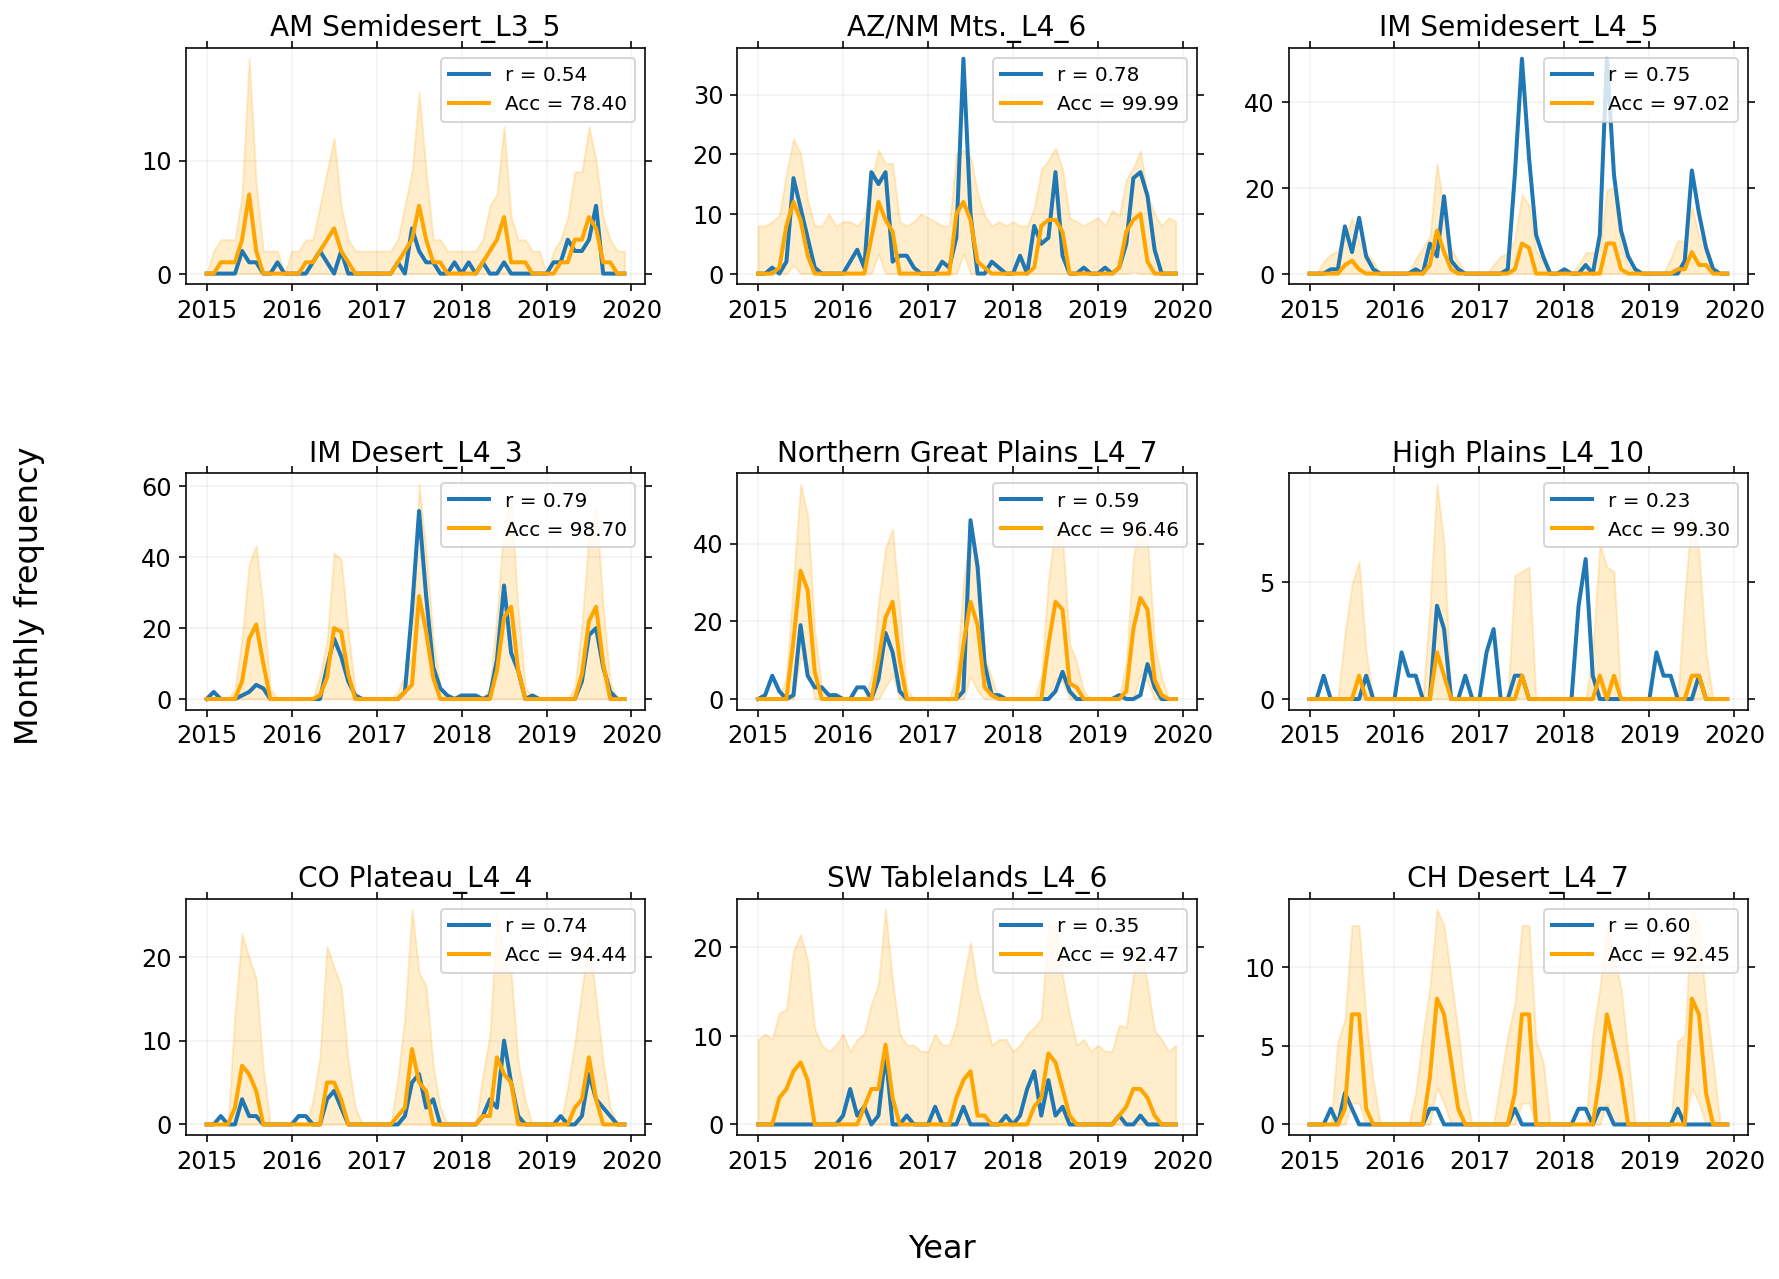

In [60]:
fig, ax= plt.subplots(3, 3, figsize=(14, 10))
#plt.suptitle(r'Monthly fire frequency across regions', fontsize= 18);
fig.text(0.04, 0.5, r'Monthly frequency', va='center', rotation='vertical', fontsize= 16);
fig.text(0.5, 0.04, r'Year', ha='center', fontsize= 16)

for i in tqdm(range(3)):
    for j in range(3):
        regindx= ind_grid_2[i][j]
        mod_params= hp_df.loc[opt_freq_ind[regindx - 1]].to_dict()
        
        if mod_params['reg_flag'] == 'L4':
            if mod_params['func_flag'] == 'zipd':
                mdn_L4_zipd= tf.keras.models.load_model('../sav_files/iter_runs_22_01_13/mdn_L4_zipd_iter_%d'%(mod_params['Iteration']), \
                                                                                    custom_objects= {'zipd_loss': zipd_loss, 'zipd_accuracy': zipd_accuracy})
                reg_L4_freq_df= freq_pred_func(mdn_model= mdn_L4_zipd, X_test_dat= X_L4_freqs_test, func_flag= 'zipd', l4_flag= True, reg_len_arr= reglenarr, modsave= True)
            else:
                mdn_L4_zinb= tf.keras.models.load_model('../sav_files/iter_runs_22_01_13/mdn_L4_zinb_iter_%d'%(mod_params['Iteration']), \
                                                                                    custom_objects= {'zinb_loss': zinb_loss, 'zinb_accuracy': zinb_accuracy})
                reg_L4_freq_df= freq_pred_func(mdn_model= mdn_L4_zinb, X_test_dat= X_L4_freqs_test, func_flag= 'zipd', l4_flag= True, reg_len_arr= reglenarr, modsave= True)

            reg_L4_freq_groups= reg_L4_freq_df.groupby('reg_indx')
            fire_l3_mean_freqs= np.asarray([np.sum(reg_L4_freq_groups.get_group(regindx)['mean_freq'].iloc[np.arange(m, reglenarr[regindx - 1], tot_months)]) \
                                                                                            for m in range(tot_months)])
            fire_l3_high_freqs= fire_l3_mean_freqs + 2*np.sqrt([np.sum(reg_L4_freq_groups.get_group(regindx)['std_freq'].iloc[np.arange(m, reglenarr[regindx - 1], tot_months)]**2) \
                                    for m in range(tot_months)])
            fire_l3_low_freqs= fire_l3_mean_freqs - 2*np.sqrt([np.sum(reg_L4_freq_groups.get_group(regindx)['std_freq'].iloc[np.arange(m, reglenarr[regindx - 1], tot_months)]**2) \
                                    for m in range(tot_months)])
            fire_l3_low_freqs[fire_l3_low_freqs < 0]= 0

            ax[i, j].plot(month_arr, np.asarray([np.sum(y_L4_freqs_test[cumreglen[regindx - 1]:cumreglen[regindx]][np.arange(m, reglenarr[regindx - 1], tot_months)]) \
                                                for m in range(tot_months)]), lw= 2, \
                                                label= 'r = %.2f'%mod_params['Pearson_r']);
            ax[i, j].plot(month_arr, fire_l3_mean_freqs, color= 'orange', lw= 2, \
                   label= 'Acc = %.2f'%mod_params['Accuracy']);
            ax[i, j].fill_between(month_arr, fire_l3_high_freqs, fire_l3_low_freqs, color= 'orange', alpha=0.2);
        else:
            if mod_params['func_flag'] == 'zipd':
                mdn_L3_zipd= tf.keras.models.load_model('../sav_files/iter_runs_22_01_13/mdn_L3_zipd_iter_%d'%(mod_params['Iteration']), \
                                                        custom_objects= {'zipd_loss': zipd_loss, 'zipd_accuracy': zipd_accuracy})
                reg_L3_freq_df= freq_pred_func(mdn_model= mdn_L3_zipd, X_test_dat= X_L3_freqs_test, func_flag= 'zipd', l4_flag= False, modsave= True)
            else:
                mdn_L3_zinb= tf.keras.models.load_model('../sav_files/iter_runs_22_01_13/mdn_L3_zinb_iter_%d'%(mod_params['Iteration']), \
                                                        custom_objects= {'zinb_loss': zinb_loss, 'zinb_accuracy': zinb_accuracy})
                reg_L3_freq_df= freq_pred_func(mdn_model= mdn_L3_zinb, X_test_dat= X_L3_freqs_test, func_flag= 'zinb', l4_flag= False, modsave= True)

            reg_L3_freq_groups= reg_L3_freq_df.groupby('reg_indx')
            ax[i, j].plot(month_arr, y_L3_freqs_test[freq_arr_1[regindx - 1]:freq_arr_2[regindx - 1]], lw= 2, \
                                                label= 'r = %.2f'%mod_params['Pearson_r']);
            ax[i, j].plot(month_arr, reg_L3_freq_groups.get_group(regindx)['mean_freq'], color= 'orange', lw= 2, \
                                                label= 'Acc = %.2f'%mod_params['Accuracy']);
            ax[i, j].fill_between(month_arr, reg_L3_freq_groups.get_group(regindx)['high_2sig_freq'], reg_L3_freq_groups.get_group(regindx)['low_2sig_freq'], \
                                                                                                                                     color= 'orange', alpha=0.2);

        ax[i, j].set_title('%s_'%reg_name[regindx] + '%s_'%mod_params['reg_flag'] + '%s'%mod_params['Iteration'], fontsize= 14);
        ax[i, j].set_xticks((year_arr - 2015)*12);
        ax[i, j].set_xticklabels(year_arr)
        fig.subplots_adjust(hspace= 0.8)
        #fig.minorticks_on()
        ax[i, j].legend(loc='upper right', frameon= True);
        ax[i, j].tick_params(labeltop=False, top=True, labelright=False, right=True, which='both', labelsize= 12);
        ax[i, j].grid(b=True, which='major', color='black', alpha=0.05, linestyle='-');
        ax[i, j].grid(b=True, which='minor', color='black', alpha=0.01, linestyle='-');

In [84]:
l4_freqs= y_L4_freqs_test[cumreglen[11]:cumreglen[12]]
obs_input= X_L4_freqs_test[cumreglen[11]:cumreglen[12]]

mdn_L4_zipd= tf.keras.models.load_model('../sav_files/iter_runs_22_01_13/mdn_L4_zipd_iter_5', \
                                                                                    custom_objects= {'zipd_loss': zipd_loss, 'zipd_accuracy': zipd_accuracy})
param_vec= mdn_L4_zipd.predict(x= tf.constant(obs_input))

In [92]:
cdf_mod= zipd_model(param_vec).cdf(y_L4_freqs_test[cumreglen[11]:cumreglen[12]])

In [88]:
empcdf= tfd.Empirical(y_L4_freqs_test[cumreglen[11]:cumreglen[12]])
cdf_emp= empcdf.cdf(y_L4_freqs_test[cumreglen[11]:cumreglen[12]])

(0.65, 1.02)

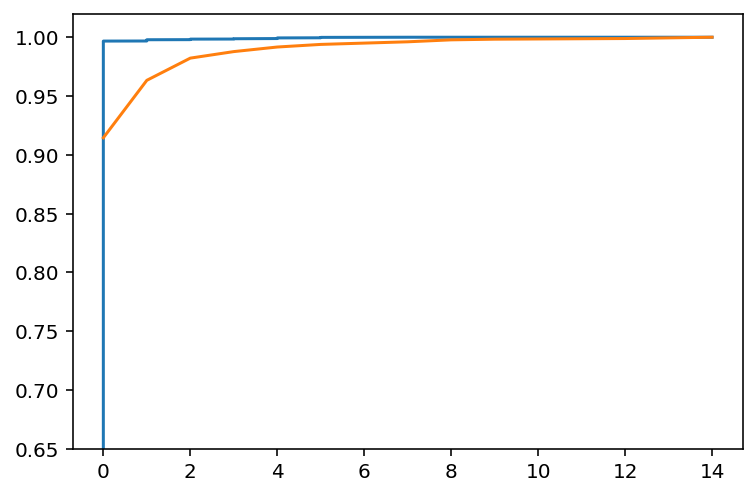

In [106]:
plt.plot(np.sort(y_L4_freqs_test[cumreglen[11]:cumreglen[12]]), np.sort(cdf_mod.numpy()))
plt.plot(np.sort(y_L4_freqs_test[cumreglen[11]:cumreglen[12]]), np.sort(cdf_emp))
plt.ylim(0.65, 1.02)

In [201]:
zipd_model(param_vec)

NotImplementedError: quantile is not implemented: Mixture

In [175]:
X_1= zipd_model(param_vec).sample(10000)
X_2= zipd_model(param_vec).sample(10000)

crps= 0.5*tf.reduce_mean(tf.abs(X_1 - X_2), axis= 0) - tf.reduce_mean(tf.abs(X_1 - y_L4_freqs_test[cumreglen[11]:cumreglen[12]]), axis= 0)

In [196]:
mdn_L3_zinb= tf.keras.models.load_model('../sav_files/iter_runs_22_01_13/mdn_L4_zipd_iter_3', \
                                                                                    custom_objects= {'zipd_loss': zipd_loss, 'zipd_accuracy': zipd_accuracy})
param_vec= mdn_L3_zinb.predict(x= tf.constant(obs_input))

In [197]:
X_1_prime= zipd_model(param_vec).sample(10000)
X_2_prime= zipd_model(param_vec).sample(10000)

crps_prime= 0.5*tf.reduce_mean(tf.abs(X_1_prime - X_2_prime), axis= 0) - tf.reduce_mean(tf.abs(X_1_prime - y_L4_freqs_test[cumreglen[11]:cumreglen[12]]), axis= 0)

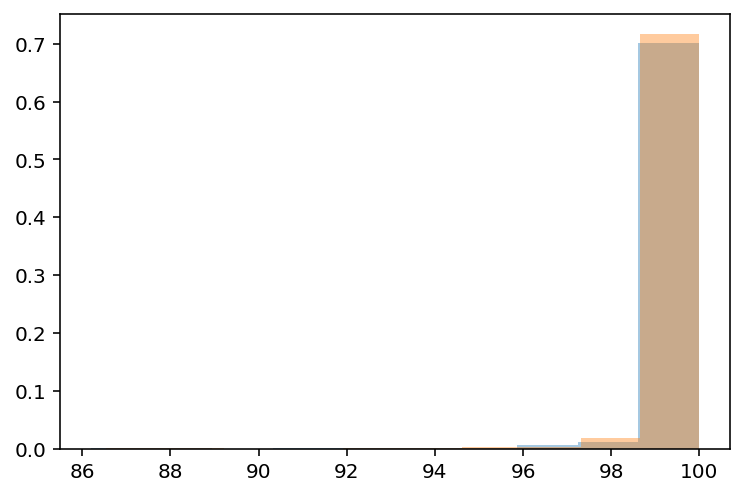

In [198]:
plt.hist(100 - np.abs(crps), bins= 10, density= True, alpha= 0.4);
plt.hist(100 - np.abs(crps_prime), bins= 10, density= True, alpha= 0.4);

In [199]:
tfp.stats.percentile(100 - tf.abs(crps), 50.0, interpolation='midpoint', axis= 0)

<tf.Tensor: shape=(), dtype=float32, numpy=99.9984>

In [200]:
tfp.stats.percentile(100 - tf.abs(crps_prime), 50.0, interpolation='midpoint', axis= 0)

<tf.Tensor: shape=(), dtype=float32, numpy=99.9965>

In [83]:
hp_df.groupby('reg_indx').get_group(12).sort_values(by= ['tot_metric'], ascending= False)

,Iteration,reg_indx,reg_flag,func_flag,Pearson_r,Red_ChiSq,Accuracy,tot_metric
335,5,12,L4,zipd,0.748442,728.115094,97.023041,72.616146
191,3,12,L4,zipd,0.715239,75.691683,97.875687,70.004538
406,6,12,L4,zinb,0.709484,596.406475,96.889992,68.741912
263,4,12,L4,zipd,0.691487,429.520016,98.056702,67.804933
479,7,12,L4,zipd,0.690961,98.660700,97.518921,67.381768
119,2,12,L4,zipd,0.657508,436.789018,98.696587,64.893787
333,5,12,L3,zipd,0.697401,1007.694592,92.490280,64.502837
46,1,12,L4,zinb,0.652885,189.618130,98.719650,64.452552
261,4,12,L3,zipd,0.668481,815.996922,93.838493,62.729219
623,9,12,L4,zipd,0.638727,65.605964,97.859322,62.505355


100%|██████████| 18/18 [00:25<00:00,  1.39s/it]


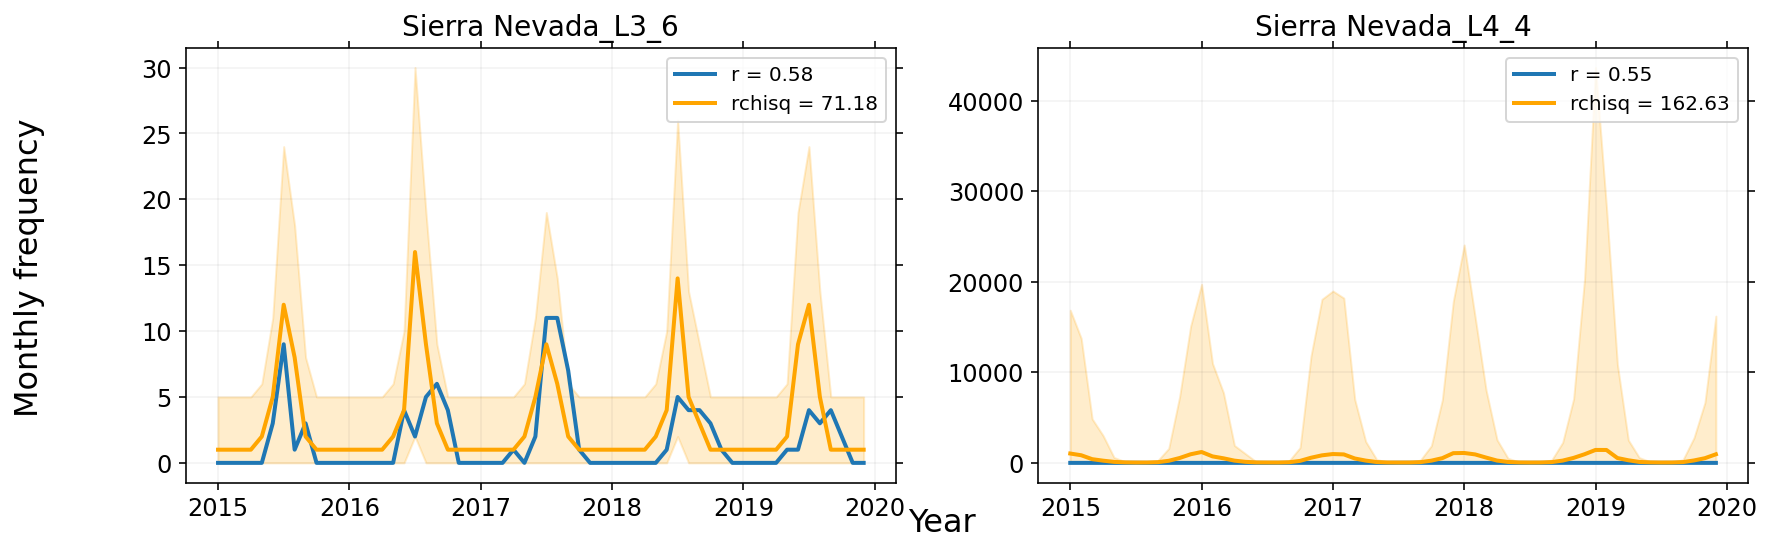

In [82]:
fig, ax= plt.subplots(1, 2, figsize=(14, 4))
#plt.suptitle(r'Monthly fire frequency across regions', fontsize= 18);
fig.text(0.04, 0.5, r'Monthly frequency', va='center', rotation='vertical', fontsize= 16);
fig.text(0.5, 0.04, r'Year', ha='center', fontsize= 16)

regindx= 1
mod_1_params= {'Iteration': 6, 'reg_flag': 'L3', 'func_flag': 'zipd', 'best_ind': 13}
mod_2_params= {'Iteration': 4, 'reg_flag': 'L4', 'func_flag': 'zinb', 'best_ind': 14}
        
if mod_1_params['reg_flag'] == 'L4':
    if mod_1_params['func_flag'] == 'zipd':
        mdn_L4_zipd= tf.keras.models.load_model('../sav_files/iter_runs_22_01_13/mdn_L4_zipd_iter_%d'%(mod_1_params['Iteration']), \
                                                                            custom_objects= {'zipd_loss': zipd_loss, 'zipd_accuracy': zipd_accuracy})
        reg_L4_freq_df= freq_pred_func(mdn_model= mdn_L4_zipd, X_test_dat= X_L4_freqs_test, func_flag= 'zipd', l4_flag= True, reg_len_arr= reglenarr, modsave= False)
    else:
        mdn_L4_zinb= tf.keras.models.load_model('../sav_files/iter_runs_22_01_13/mdn_L4_zinb_iter_%d'%(mod_1_params['Iteration']), \
                                                                            custom_objects= {'zinb_loss': zinb_loss, 'zinb_accuracy': zinb_accuracy})
        reg_L4_freq_df= freq_pred_func(mdn_model= mdn_L4_zinb, X_test_dat= X_L4_freqs_test, func_flag= 'zipd', l4_flag= True, reg_len_arr= reglenarr, modsave= False)
    
    reg_L4_freq_groups= reg_L4_freq_df.groupby('reg_indx')
    fire_l3_mean_freqs= np.asarray([np.sum(reg_L4_freq_groups.get_group(regindx)['mean_freq'].iloc[np.arange(m, reglenarr[regindx - 1], tot_months)]) \
                                                                                    for m in range(tot_months)])
    fire_l3_high_freqs= fire_l3_mean_freqs + 2*np.sqrt([np.sum(reg_L4_freq_groups.get_group(regindx)['std_freq'].iloc[np.arange(m, reglenarr[regindx - 1], tot_months)]**2) \
                            for m in range(tot_months)])
    fire_l3_low_freqs= fire_l3_mean_freqs - 2*np.sqrt([np.sum(reg_L4_freq_groups.get_group(regindx)['std_freq'].iloc[np.arange(m, reglenarr[regindx - 1], tot_months)]**2) \
                            for m in range(tot_months)])
    fire_l3_low_freqs[fire_l3_low_freqs < 0]= 0

    ax[0].plot(month_arr, np.asarray([np.sum(y_L4_freqs_test[cumreglen[regindx - 1]:cumreglen[regindx]][np.arange(m, reglenarr[regindx - 1], tot_months)]) \
                                        for m in range(tot_months)]), lw= 2, \
                                        label= 'r = %.2f'%hp_df.groupby('reg_indx').get_group(regindx).sort_values(by= ['tot_metric'], ascending= False).iloc[mod_1_params['best_ind']]['Pearson_r']);
    ax[0].plot(month_arr, fire_l3_mean_freqs, color= 'orange', lw= 2, \
           label= 'rchisq = %.2f'%hp_df.groupby('reg_indx').get_group(regindx).sort_values(by= ['tot_metric'], ascending= False).iloc[mod_1_params['best_ind']]['Red_ChiSq']);
    ax[0].fill_between(month_arr, fire_l3_high_freqs, fire_l3_low_freqs, color= 'orange', alpha=0.2);
else:
    if mod_1_params['func_flag'] == 'zipd':
        mdn_L3_zipd= tf.keras.models.load_model('../sav_files/iter_runs_22_01_13/mdn_L3_zipd_iter_%d'%(mod_1_params['Iteration']), \
                                                custom_objects= {'zipd_loss': zipd_loss, 'zipd_accuracy': zipd_accuracy})
        reg_L3_freq_df= freq_pred_func(mdn_model= mdn_L3_zipd, X_test_dat= X_L3_freqs_test, func_flag= 'zipd', l4_flag= False, modsave= False)
    else:
        mdn_L3_zinb= tf.keras.models.load_model('../sav_files/iter_runs_22_01_13/mdn_L3_zinb_iter_%d'%(mod_1_params['Iteration']), \
                                                custom_objects= {'zinb_loss': zinb_loss, 'zinb_accuracy': zinb_accuracy})
        reg_L3_freq_df= freq_pred_func(mdn_model= mdn_L3_zinb, X_test_dat= X_L3_freqs_test, func_flag= 'zinb', l4_flag= False, modsave= False)
        
    reg_L3_freq_groups= reg_L3_freq_df.groupby('reg_indx')
    ax[0].plot(month_arr, y_L3_freqs_test[freq_arr_1[regindx - 1]:freq_arr_2[regindx - 1]], lw= 2, \
                                        label= 'r = %.2f'%hp_df.groupby('reg_indx').get_group(regindx).sort_values(by= ['tot_metric'], ascending= False).iloc[mod_1_params['best_ind']]['Pearson_r']);
    ax[0].plot(month_arr, reg_L3_freq_groups.get_group(regindx)['mean_freq'], color= 'orange', lw= 2, \
                                        label= 'rchisq = %.2f'%hp_df.groupby('reg_indx').get_group(regindx).sort_values(by= ['tot_metric'], ascending= False).iloc[mod_1_params['best_ind']]['Red_ChiSq']);
    ax[0].fill_between(month_arr, reg_L3_freq_groups.get_group(regindx)['high_2sig_freq'], reg_L3_freq_groups.get_group(regindx)['low_2sig_freq'], \
                                                                                                                             color= 'orange', alpha=0.2);
       
ax[0].set_title('%s_'%reg_name[regindx] + '%s_'%mod_1_params['reg_flag'] + '%s'%mod_1_params['Iteration'], fontsize= 14);
ax[0].set_xticks((year_arr - 2015)*12);
ax[0].set_xticklabels(year_arr)
fig.subplots_adjust(hspace= 0.8)
#fig.minorticks_on()
ax[0].legend(loc='upper right', frameon= True);
ax[0].tick_params(labeltop=False, top=True, labelright=False, right=True, which='both', labelsize= 12);
ax[0].grid(b=True, which='major', color='black', alpha=0.05, linestyle='-');
ax[0].grid(b=True, which='minor', color='black', alpha=0.01, linestyle='-');

if mod_2_params['reg_flag'] == 'L4':
    if mod_2_params['func_flag'] == 'zipd':
        mdn_L4_zipd= tf.keras.models.load_model('../sav_files/iter_runs_22_01_13/mdn_L4_zipd_iter_%d'%(mod_2_params['Iteration']), \
                                                                            custom_objects= {'zipd_loss': zipd_loss, 'zipd_accuracy': zipd_accuracy})
        reg_L4_freq_df= freq_pred_func(mdn_model= mdn_L4_zipd, X_test_dat= X_L4_freqs_test, func_flag= 'zipd', l4_flag= True, reg_len_arr= reglenarr, modsave= False)
    else:
        mdn_L4_zinb= tf.keras.models.load_model('../sav_files/iter_runs_22_01_13/mdn_L4_zinb_iter_%d'%(mod_2_params['Iteration']), \
                                                                            custom_objects= {'zinb_loss': zinb_loss, 'zinb_accuracy': zinb_accuracy})
        reg_L4_freq_df= freq_pred_func(mdn_model= mdn_L4_zinb, X_test_dat= X_L4_freqs_test, func_flag= 'zipd', l4_flag= True, reg_len_arr= reglenarr, modsave= False)
    
    reg_L4_freq_groups= reg_L4_freq_df.groupby('reg_indx')
    fire_l3_mean_freqs= np.asarray([np.sum(reg_L4_freq_groups.get_group(regindx)['mean_freq'].iloc[np.arange(m, reglenarr[regindx - 1], tot_months)]) \
                                                                                    for m in range(tot_months)])
    fire_l3_high_freqs= fire_l3_mean_freqs + 2*np.sqrt([np.sum(reg_L4_freq_groups.get_group(regindx)['std_freq'].iloc[np.arange(m, reglenarr[regindx - 1], tot_months)]**2) \
                            for m in range(tot_months)])
    fire_l3_low_freqs= fire_l3_mean_freqs - 2*np.sqrt([np.sum(reg_L4_freq_groups.get_group(regindx)['std_freq'].iloc[np.arange(m, reglenarr[regindx - 1], tot_months)]**2) \
                            for m in range(tot_months)])
    fire_l3_low_freqs[fire_l3_low_freqs < 0]= 0

    ax[1].plot(month_arr, np.asarray([np.sum(y_L4_freqs_test[cumreglen[regindx - 1]:cumreglen[regindx]][np.arange(m, reglenarr[regindx - 1], tot_months)]) \
                                        for m in range(tot_months)]), lw= 2, \
                                        label= 'r = %.2f'%hp_df.groupby('reg_indx').get_group(regindx).sort_values(by= ['tot_metric'], ascending= False).iloc[mod_2_params['best_ind']]['Pearson_r']);
    ax[1].plot(month_arr, fire_l3_mean_freqs, color= 'orange', lw= 2, \
           label= 'rchisq = %.2f'%hp_df.groupby('reg_indx').get_group(regindx).sort_values(by= ['tot_metric'], ascending= False).iloc[mod_2_params['best_ind']]['Red_ChiSq']);
    ax[1].fill_between(month_arr, fire_l3_high_freqs, fire_l3_low_freqs, color= 'orange', alpha=0.2);
else:
    if mod_2_params['func_flag'] == 'zipd':
        mdn_L3_zipd= tf.keras.models.load_model('../sav_files/iter_runs_22_01_13/mdn_L3_zipd_iter_%d'%(mod_2_params['Iteration']), \
                                                custom_objects= {'zipd_loss': zipd_loss, 'zipd_accuracy': zipd_accuracy})
        reg_L3_freq_df= freq_pred_func(mdn_model= mdn_L3_zipd, X_test_dat= X_L3_freqs_test, func_flag= 'zipd', l4_flag= False, modsave= False)
    else:
        mdn_L3_zinb= tf.keras.models.load_model('../sav_files/iter_runs_22_01_13/mdn_L3_zinb_iter_%d'%(mod_2_params['Iteration']), \
                                                custom_objects= {'zinb_loss': zinb_loss, 'zinb_accuracy': zinb_accuracy})
        reg_L3_freq_df= freq_pred_func(mdn_model= mdn_L3_zinb, X_test_dat= X_L3_freqs_test, func_flag= 'zinb', l4_flag= False, modsave= False)
        
    reg_L3_freq_groups= reg_L3_freq_df.groupby('reg_indx')
    ax[1].plot(month_arr, y_L3_freqs_test[freq_arr_1[regindx - 1]:freq_arr_2[regindx - 1]], lw= 2, \
                                        label= 'r = %.2f'%hp_df.groupby('reg_indx').get_group(regindx).sort_values(by= ['tot_metric'], ascending= False).iloc[mod_2_params['best_ind']]['Pearson_r']);
    ax[1].plot(month_arr, reg_L3_freq_groups.get_group(regindx)['mean_freq'], color= 'orange', lw= 2, \
                                        label= 'rchisq = %.2f'%hp_df.groupby('reg_indx').get_group(regindx).sort_values(by= ['tot_metric'], ascending= False).iloc[mod_2_params['best_ind']]['Red_ChiSq']);
    ax[1].fill_between(month_arr, reg_L3_freq_groups.get_group(regindx)['high_2sig_freq'], reg_L3_freq_groups.get_group(regindx)['low_2sig_freq'], \
                                                                                                                             color= 'orange', alpha=0.2);
    
ax[1].set_title('%s_'%reg_name[regindx] + '%s_'%mod_2_params['reg_flag'] + '%s'%mod_2_params['Iteration'], fontsize= 14);
ax[1].set_xticks((year_arr - 2015)*12);
ax[1].set_xticklabels(year_arr)
fig.subplots_adjust(hspace= 0.8)
ax[1].legend(loc='upper right', frameon= True);

ax[1].tick_params(labeltop=False, top=True, labelright=False, right=True, which='both', labelsize= 12);
ax[1].grid(b=True, which='major', color='black', alpha=0.05, linestyle='-');
ax[1].grid(b=True, which='minor', color='black', alpha=0.01, linestyle='-');
#plt.savefig('../plots/ml_L4_fire_freq_1_alt.pdf', bbox_inches='tight');

### 2.3 Fire size

In [ ]:
nregions= 18
max_fire_train_arr= []
sum_fire_train_arr= []

for r in tqdm(range(nregions)):
    max_fire_train_arr.append(np.max(np.concatenate([fire_size_train.groupby('reg_indx').get_group(r+1).groupby('fire_month').get_group(k).fire_size.to_numpy()/1e6 for k in fire_size_train.groupby('reg_indx').get_group(r+1).groupby('fire_month').groups.keys()])))
    sum_fire_train_arr.append(np.max([np.sum(fire_size_train.groupby('reg_indx').get_group(r+1).groupby('fire_month').get_group(k).fire_size.to_numpy()/1e6) for k in fire_size_train.groupby('reg_indx').get_group(r+1).groupby('fire_month').groups.keys()]))
    
max_fire_train_arr= np.asarray(max_fire_train_arr)
sum_fire_train_arr= np.asarray(sum_fire_train_arr)

In [ ]:
def size_pred_func(mdn_model, stat_model, size_test_df, X_test_dat, max_size_arr, sum_size_arr, freq_flag= 'ml', regmlfreqgrps= None, freqs_data= None, \
                                                                                                    debug= False, regindx= None, seed= None):
    
    # Given a NN model, the function returns the monthly burned area time series for all L3 regions
    
    tf.random.set_seed(seed)
    X_test_dat= np.array(X_test_dat, dtype= np.float32)
    
    if debug:
        n_regions= 1 #18
    else:
        n_regions= 18
    tot_months= 60
    reg_size_df= pd.DataFrame({'mean_size': pd.Series(dtype= 'int'), 'low_1sig_size': pd.Series(dtype= 'int'), 'high_1sig_size': pd.Series(dtype= 'int'), \
                                                                                           'reg_indx': pd.Series(dtype= 'int')})

    for i in tqdm(range(n_regions)): 
        if debug:
            size_ind_df= size_test_df.reset_index()[['fire_size', 'fire_month', 'reg_indx']]
            reg_ind_df= size_ind_df.groupby('reg_indx').get_group(regindx).groupby('fire_month')
        else:
            size_ind_df= size_test_df.reset_index()[['fire_size', 'fire_month', 'reg_indx']]
            reg_ind_df= size_ind_df.groupby('reg_indx').get_group(i+1).groupby('fire_month')

        mean_burnarea_tot= np.zeros(tot_months)
        high_1sig_burnarea_tot= np.zeros(tot_months)
        low_1sig_burnarea_tot= np.zeros(tot_months)
        if debug:
            fire_ind_grid= []
            ml_param_grid= []

        for m in range(tot_months):
            mindx= m + 372
            if freq_flag == 'ml':
                if debug:
                    reg_freqs= regmlfreqgrps.get_group(regindx)
                else:
                    reg_freqs= regmlfreqgrps.get_group(i+1)
                    freqs= reg_freqs['mean_freq'].iloc[[m]].to_numpy()[0] #iloc maintains month index for every region
            elif freq_flag == 'data':
                freq_size= np.int64(len(freqs_data)/18)
                tmparr_1= np.linspace(0, len(freqs_data) - freq_size, 18, dtype= np.int64)
                #tmparr_2= tmparr_1 + freq_size
                if debug:
                    freqs= freqs_data.astype(np.int64)[tmparr_1[regindx - 1] + m]
                else:
                    freqs= freqs_data.astype(np.int64)[tmparr_1[i] + m]
            
            # for sampling from frequency distribution, create additional function from here
            if freqs == 0:
                mean_burnarea_tot[m]= 0
                high_1sig_burnarea_tot[m]= 0
                low_1sig_burnarea_tot[m]= 0
                if debug:
                    fire_ind_grid.append(np.array([0]))
                    ml_param_grid.append(np.zeros(n_comps))

            else:
                try:
                    fire_ind_arr= reg_ind_df.get_group(mindx).index.to_numpy() #replace with random draws of grid points from a RF learned 'fire potential' map
                    if freqs <= len(fire_ind_arr):
                        fire_ind_arr= np.random.choice(fire_ind_arr, freqs, replace= False)
                    else:
                        fire_ind_arr= np.append(fire_ind_arr, np.random.choice(fire_ind_arr, freqs - len(fire_ind_arr), replace= False))

                    ml_param_vec= mdn_model.predict(x= X_test_dat[fire_ind_arr]) #note: different indexing than the fire_size_test df
                    if debug:
                        fire_ind_grid.append(fire_ind_arr)
                        ml_param_grid.append(ml_param_vec)

                    size_samp_arr= tf.reduce_mean(stat_model(ml_param_vec).sample(10000, seed= 99), axis= 0).numpy()
                    std_size_arr= tf.math.reduce_std(stat_model(ml_param_vec).sample(10000, seed= 99), axis= 0).numpy()
                    high_1sig_err= deepcopy(std_size_arr)
                    tot_l1sig_arr= np.sqrt(np.sum(std_size_arr**2))

                    size_samp_arr[size_samp_arr > 2*max_size_arr[i]]= max_size_arr[i]
                    high_1sig_err[high_1sig_err > max_size_arr[i]]= max_size_arr[i] 
                    tot_h1sig_arr= np.sqrt(np.sum(high_1sig_err**2))

                    if np.sum(size_samp_arr) > 2*sum_size_arr[i]:
                        mean_burnarea_tot[m]= sum_size_arr[i]
                    else:
                        mean_burnarea_tot[m]= np.sum(size_samp_arr)

                    high_1sig_burnarea_tot[m]= mean_burnarea_tot[m] + tot_h1sig_arr
                    low_1sig_burnarea_tot[m]= mean_burnarea_tot[m] - tot_l1sig_arr
                    if (mean_burnarea_tot[m] - tot_l1sig_arr) < 0: 
                        low_1sig_burnarea_tot[m]= 0

                    #if np.max(size_samp_arr) > max_size_arr[i]:
                    #    max_size_arr[i]= np.max(size_samp_arr)

                    #while np.sum(size_samp_arr) > 2*sum_size_arr[i]:
                    #    rseed= np.random.randint(10000)
                    #    size_samp_arr= tf.reduce_mean(stat_model(ml_param_vec).sample(10000, seed= tfp.random.sanitize_seed(rseed)), axis= 0).numpy()
                    #    std_size_arr= tf.math.reduce_std(stat_model(ml_param_vec).sample(10000, seed= tfp.random.sanitize_seed(rseed)), axis= 0).numpy()
                    #if np.sum(size_samp_arr) > sum_size_arr[i]:
                    #    sum_size_arr[i]= np.sum(size_samp_arr)

                except KeyError:
                    if freqs == 0:
                        mean_burnarea_tot[m]= 0 #current kludge and needs to be fixed
                        high_1sig_burnarea_tot[m]= 0
                        low_1sig_burnarea_tot[m]= 0
                        if debug:
                            fire_ind_grid.append(np.array([0]))
                            ml_param_grid.append(np.zeros(n_comps))

        reg_indx_arr= (i+1)*np.ones(tot_months, dtype= np.int64)
        reg_size_df= reg_size_df.append(pd.DataFrame({'mean_size': mean_burnarea_tot, 'low_1sig_size': low_1sig_burnarea_tot, 'high_1sig_size': high_1sig_burnarea_tot, \
                                                                                           'reg_indx': reg_indx_arr}), ignore_index=True)

    if debug:
        return reg_size_df, fire_ind_grid, ml_param_grid
    else:
        return reg_size_df

In [ ]:
def reg_fire_size_func(X_train_dat, y_train_dat, X_val_dat, y_val_dat, size_test_df, X_test_dat, max_size_arr= None, sum_size_arr= None, \
                                                                func_flag= 'gpd', lnc_arr= [2, 16, 2], initializer= "he_normal", regrate= 0.001, \
                                                                freq_flag= 'ml', regmlfreqgrps= None, freqs_data= None, \
                                                                shapind= False, debug= False, regindx= None, rseed= None):
    
    # Calculates the predicted fire burned areas as well as its 1 sigma uncertainty for all regions
    
    if rseed == None:
        rseed= np.random.randint(100)
    tf.random.set_seed(rseed)
    X_train_dat= np.array(X_train_dat, dtype= np.float32)
    X_val_dat= np.array(X_val_dat, dtype= np.float32)

    if func_flag == 'gpd':
        n_layers, n_neurons, n_comps= lnc_arr
        stat_model= gpd_model
        loss_func= gpd_loss
        acc_func= gpd_accuracy
         
    elif func_flag == 'lognorm':
        n_layers, n_neurons, n_comps= lnc_arr     
        stat_model= lognorm_model
        loss_func= lognorm_loss
        acc_func= lognorm_accuracy
    
    #if custom_ml_model == None:
    es_mon = EarlyStopping(monitor='val_loss', min_delta=0, patience=5, verbose=0, mode='auto')
    mdn= MDN_size(layers= n_layers, neurons= n_neurons, components= n_comps, initializer= initializer, reg= True, regrate= regrate, dropout= True)
    mdn.compile(loss=loss_func, optimizer= tf.keras.optimizers.Adam(learning_rate= 1e-4), metrics=[acc_func])
    h= mdn.fit(x= X_train_dat, y= y_train_dat, epochs= 500, validation_data=(X_val_dat, y_val_dat), callbacks= [es_mon], batch_size= 32, verbose=0) #callbacks= [es_mon],
    print("MDN trained for %d epochs"%len(h.history['loss']))
        
    if loco:
        return mdn, h
        
    else: 
        if debug:
            burnarea_df, fire_ind_grid, ml_param_grid= size_pred_func(mdn, stat_model, size_test_df, X_test_dat, max_size_arr, sum_size_arr, freq_flag, freqs_data, \
                                                                                                         debug= True, seed= rseed)
            return burnarea_df, fire_ind_grid, ml_param_grid
        else:
            burnarea_df= size_pred_func(mdn, stat_model, size_test_df, X_test_dat, max_size_arr, sum_size_arr, freq_flag= freq_flag, freqs_data= freqs_data, \
                                                                                                         debug= False, seed= rseed)
            return burnarea_df

In [8]:
def test_run_hyperparam(func= ['gpd'], lncarr=[[2, 8, 2]], initializer= ["he_normal"], l2rate= ['0.001'], n_iters= 1): #, [2, 8, 3], [2, 16, 2], [2, 16, 3]
    
    n_regions= 18
    list_of_lists = []
    
    for it in range(n_iters):
        for f in func:
            for l in lncarr:
                for init in initializer:
                    for l2r in l2rate:
                        reg_ml_size_df, h_size= reg_fire_size_func(X_train_dat= X_sizes_train, y_train_dat= y_sizes_train, X_val_dat= X_sizes_val, \
                                y_val_dat= y_sizes_val, X_test_dat= X_sizes_test, max_size_arr= max_fire_train_arr, sum_size_arr= sum_fire_train_arr, func_flag= f, lnc_arr= l, initializer= init, l2rate= l2r,\
                                                                                                                                                      freq_flag= 'data', freqs_data= fire_freq_L3_data, \
                                                                                                                                                      iter_run= it+1, sav_flag= 'hyperparams')
                        reg_ml_size_groups= reg_ml_size_df.groupby('reg_indx')

                        errarr= np.asarray([(reg_ml_size_groups.get_group(r+1)['mean_size'] - mon_burned_area(fire_file, regindx= r+1)[372:])**2/(reg_ml_size_groups.get_group(r+1)['high_1sig_size'] - reg_ml_size_groups.get_group(r+1)['mean_size']) for r in range(n_regions)])
                        chisq= np.sum(errarr[np.isfinite(errarr)])
                        dof= len(errarr) + (l[0]*l[1]**2 + l[2]) 

                        list_of_lists.append([it+1, f, l, init, float(l2r), np.nanmean(h_size.history['val_%s_accuracy'%f]), chisq/dof])
    
    hp_df= pd.DataFrame(list_of_lists, columns=["Iteration", "Function", "n_lnc", "Initializer", "L2rate", "Accuracy_1", "Accuracy_2"])
    
    return hp_df

In [9]:
hp_df= test_run_hyperparam(func= ['gpd', 'lognorm'], lncarr=[[2, 8, 2], [2, 8, 3]], initializer= ["he_normal", "glorot_uniform"], l2rate= ['0.01', '0.001'], n_iters= 5)
#hp_df.to_hdf('../sav_files/hyperparams_iter_runs_03_12_21.h5', key= 'df', mode= 'w')

Metal device set to: Apple M1


2021-12-03 20:16:21.284410: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2021-12-03 20:16:21.284525: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
2021-12-03 20:16:21.445688: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
2021-12-03 20:16:21.445914: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2021-12-03 20:16:21.953333: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2021-12-03 20:16:26.408721: I tensorflow/core/grappler/

MDN trained for 177 epochs


2021-12-03 20:29:50.180617: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: ../sav_files/hyperparams_gpd_8_2_he_normal_0.01_iter_1/assets


2021-12-03 20:29:50.678179: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2021-12-03 20:30:08.679744: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2021-12-03 20:30:26.461075: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2021-12-03 20:30:31.015338: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


MDN trained for 183 epochs
INFO:tensorflow:Assets written to: ../sav_files/hyperparams_gpd_8_2_he_normal_0.001_iter_1/assets


2021-12-03 20:44:32.278793: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2021-12-03 20:44:50.293793: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2021-12-03 20:45:07.603185: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2021-12-03 20:45:12.071319: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


MDN trained for 241 epochs
INFO:tensorflow:Assets written to: ../sav_files/hyperparams_gpd_8_2_glorot_uniform_0.01_iter_1/assets


2021-12-03 21:03:43.812957: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2021-12-03 21:04:01.671846: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2021-12-03 21:04:18.916236: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2021-12-03 21:04:23.420063: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


MDN trained for 151 epochs
INFO:tensorflow:Assets written to: ../sav_files/hyperparams_gpd_8_2_glorot_uniform_0.001_iter_1/assets


2021-12-03 21:15:58.793978: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2021-12-03 21:16:17.331463: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2021-12-03 21:16:34.664967: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2021-12-03 21:16:39.284367: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


MDN trained for 165 epochs
INFO:tensorflow:Assets written to: ../sav_files/hyperparams_gpd_8_3_he_normal_0.01_iter_1/assets


2021-12-03 21:29:24.821547: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2021-12-03 21:29:44.028284: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2021-12-03 21:30:01.971282: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2021-12-03 21:30:06.584925: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


MDN trained for 210 epochs
INFO:tensorflow:Assets written to: ../sav_files/hyperparams_gpd_8_3_he_normal_0.001_iter_1/assets


2021-12-03 21:46:32.452408: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2021-12-03 21:46:51.941475: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2021-12-03 21:47:10.139479: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2021-12-03 21:47:14.776120: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


MDN trained for 149 epochs
INFO:tensorflow:Assets written to: ../sav_files/hyperparams_gpd_8_3_glorot_uniform_0.01_iter_1/assets


2021-12-03 21:58:49.918280: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2021-12-03 21:59:09.207401: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2021-12-03 21:59:27.112342: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2021-12-03 21:59:31.792379: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


MDN trained for 192 epochs
INFO:tensorflow:Assets written to: ../sav_files/hyperparams_gpd_8_3_glorot_uniform_0.001_iter_1/assets


2021-12-03 22:14:29.317554: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2021-12-03 22:14:48.599566: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2021-12-03 22:15:06.506135: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2021-12-03 22:15:11.878363: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


MDN trained for 185 epochs
INFO:tensorflow:Assets written to: ../sav_files/hyperparams_lognorm_8_2_he_normal_0.01_iter_1/assets


2021-12-03 22:30:33.145845: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2021-12-03 22:30:51.135457: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2021-12-03 22:31:08.568552: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2021-12-03 22:31:13.790057: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


MDN trained for 144 epochs
INFO:tensorflow:Assets written to: ../sav_files/hyperparams_lognorm_8_2_he_normal_0.001_iter_1/assets


2021-12-03 22:43:05.499437: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2021-12-03 22:43:23.152126: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2021-12-03 22:43:41.196772: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2021-12-03 22:43:46.195640: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


MDN trained for 101 epochs
INFO:tensorflow:Assets written to: ../sav_files/hyperparams_lognorm_8_2_glorot_uniform_0.01_iter_1/assets


2021-12-03 22:52:08.464558: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2021-12-03 22:52:27.241016: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2021-12-03 22:52:45.419782: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2021-12-03 22:52:50.423119: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


MDN trained for 184 epochs
INFO:tensorflow:Assets written to: ../sav_files/hyperparams_lognorm_8_2_glorot_uniform_0.001_iter_1/assets


2021-12-03 23:08:04.481293: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2021-12-03 23:08:23.470853: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2021-12-03 23:08:41.443207: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2021-12-03 23:08:46.471218: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


MDN trained for 97 epochs
INFO:tensorflow:Assets written to: ../sav_files/hyperparams_lognorm_8_3_he_normal_0.01_iter_1/assets


2021-12-03 23:16:48.954772: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2021-12-03 23:17:07.230493: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2021-12-03 23:17:24.276710: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2021-12-03 23:17:29.389279: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


MDN trained for 210 epochs
INFO:tensorflow:Assets written to: ../sav_files/hyperparams_lognorm_8_3_he_normal_0.001_iter_1/assets


2021-12-03 23:34:51.916881: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2021-12-03 23:35:11.271876: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2021-12-03 23:35:29.382826: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2021-12-03 23:35:34.581939: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


MDN trained for 207 epochs
INFO:tensorflow:Assets written to: ../sav_files/hyperparams_lognorm_8_3_glorot_uniform_0.01_iter_1/assets


2021-12-03 23:52:53.476551: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2021-12-03 23:53:12.913414: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2021-12-03 23:53:31.160997: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2021-12-03 23:53:36.239198: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


MDN trained for 189 epochs
INFO:tensorflow:Assets written to: ../sav_files/hyperparams_lognorm_8_3_glorot_uniform_0.001_iter_1/assets


2021-12-04 00:09:17.575508: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2021-12-04 00:09:36.793633: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2021-12-04 00:09:54.673218: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2021-12-04 00:09:59.589310: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


MDN trained for 5 epochs
INFO:tensorflow:Assets written to: ../sav_files/hyperparams_gpd_8_2_he_normal_0.01_iter_2/assets


2021-12-04 00:10:20.414244: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2021-12-04 00:10:41.194915: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
/var/folders/l0/hrygmj0j75scyr71140zzkzm0000gn/T/ipykernel_1877/897357379.py:21: RuntimeWarning: Mean of empty slice
  list_of_lists.append([it+1, f, l, init, float(l2r), np.nanmean(h_size.history['val_%s_accuracy'%f]), chisq/dof])
2021-12-04 00:10:59.332930: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2021-12-04 00:11:04.137550: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


MDN trained for 198 epochs
INFO:tensorflow:Assets written to: ../sav_files/hyperparams_gpd_8_2_he_normal_0.001_iter_2/assets


2021-12-04 00:26:34.481383: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2021-12-04 00:26:55.398525: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2021-12-04 00:27:14.301737: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2021-12-04 00:27:19.226063: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


MDN trained for 191 epochs
INFO:tensorflow:Assets written to: ../sav_files/hyperparams_gpd_8_2_glorot_uniform_0.01_iter_2/assets


2021-12-04 00:42:16.512015: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2021-12-04 00:42:37.751289: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2021-12-04 00:42:56.685679: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2021-12-04 00:43:01.771118: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


MDN trained for 225 epochs
INFO:tensorflow:Assets written to: ../sav_files/hyperparams_gpd_8_2_glorot_uniform_0.001_iter_2/assets


2021-12-04 01:00:36.517778: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2021-12-04 01:00:57.959612: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2021-12-04 01:01:16.464353: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2021-12-04 01:01:21.447076: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


MDN trained for 148 epochs
INFO:tensorflow:Assets written to: ../sav_files/hyperparams_gpd_8_3_he_normal_0.01_iter_2/assets


2021-12-04 01:12:55.748340: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2021-12-04 01:13:17.627107: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2021-12-04 01:13:36.386118: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2021-12-04 01:13:41.501650: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


MDN trained for 139 epochs
INFO:tensorflow:Assets written to: ../sav_files/hyperparams_gpd_8_3_he_normal_0.001_iter_2/assets


2021-12-04 01:24:36.907074: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2021-12-04 01:24:58.604222: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2021-12-04 01:25:17.403098: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2021-12-04 01:25:22.538838: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


MDN trained for 185 epochs
INFO:tensorflow:Assets written to: ../sav_files/hyperparams_gpd_8_3_glorot_uniform_0.01_iter_2/assets


2021-12-04 01:39:54.229887: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2021-12-04 01:40:15.918760: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2021-12-04 01:40:34.546468: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2021-12-04 01:40:39.908985: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


MDN trained for 114 epochs
INFO:tensorflow:Assets written to: ../sav_files/hyperparams_gpd_8_3_glorot_uniform_0.001_iter_2/assets


2021-12-04 01:49:36.943748: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2021-12-04 01:49:58.422071: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2021-12-04 01:50:16.947992: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2021-12-04 01:50:22.241364: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


MDN trained for 157 epochs
INFO:tensorflow:Assets written to: ../sav_files/hyperparams_lognorm_8_2_he_normal_0.01_iter_2/assets


2021-12-04 02:03:26.883086: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2021-12-04 02:03:47.497980: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2021-12-04 02:04:05.383361: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2021-12-04 02:04:10.827270: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


MDN trained for 156 epochs
INFO:tensorflow:Assets written to: ../sav_files/hyperparams_lognorm_8_2_he_normal_0.001_iter_2/assets


2021-12-04 02:17:04.207493: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2021-12-04 02:17:25.584912: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2021-12-04 02:17:44.228453: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2021-12-04 02:17:49.565299: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


MDN trained for 182 epochs
INFO:tensorflow:Assets written to: ../sav_files/hyperparams_lognorm_8_2_glorot_uniform_0.01_iter_2/assets


2021-12-04 02:33:03.383338: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2021-12-04 02:33:24.978402: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2021-12-04 02:33:43.605350: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2021-12-04 02:33:49.218002: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


MDN trained for 155 epochs
INFO:tensorflow:Assets written to: ../sav_files/hyperparams_lognorm_8_2_glorot_uniform_0.001_iter_2/assets


2021-12-04 02:46:33.943087: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2021-12-04 02:46:55.282446: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2021-12-04 02:47:13.750741: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2021-12-04 02:47:19.234713: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


MDN trained for 173 epochs
INFO:tensorflow:Assets written to: ../sav_files/hyperparams_lognorm_8_3_he_normal_0.01_iter_2/assets


2021-12-04 03:01:46.664426: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2021-12-04 03:02:08.431206: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2021-12-04 03:02:27.191440: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2021-12-04 03:02:32.494337: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


MDN trained for 161 epochs
INFO:tensorflow:Assets written to: ../sav_files/hyperparams_lognorm_8_3_he_normal_0.001_iter_2/assets


2021-12-04 03:15:50.351944: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2021-12-04 03:16:11.866878: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2021-12-04 03:16:30.291605: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2021-12-04 03:16:35.746127: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


MDN trained for 252 epochs
INFO:tensorflow:Assets written to: ../sav_files/hyperparams_lognorm_8_3_glorot_uniform_0.01_iter_2/assets


2021-12-04 03:37:36.525520: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2021-12-04 03:37:58.194679: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2021-12-04 03:38:16.693930: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2021-12-04 03:38:21.964821: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


MDN trained for 157 epochs
INFO:tensorflow:Assets written to: ../sav_files/hyperparams_lognorm_8_3_glorot_uniform_0.001_iter_2/assets


2021-12-04 03:51:21.775769: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2021-12-04 03:51:43.512446: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2021-12-04 03:52:02.283409: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2021-12-04 03:52:07.390929: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


MDN trained for 181 epochs
INFO:tensorflow:Assets written to: ../sav_files/hyperparams_gpd_8_2_he_normal_0.01_iter_3/assets


2021-12-04 04:06:18.870203: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2021-12-04 04:06:42.970285: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2021-12-04 04:07:02.174247: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2021-12-04 04:07:07.234104: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


MDN trained for 177 epochs
INFO:tensorflow:Assets written to: ../sav_files/hyperparams_gpd_8_2_he_normal_0.001_iter_3/assets


2021-12-04 04:20:53.119997: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2021-12-04 04:21:17.253954: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2021-12-04 04:21:36.606466: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2021-12-04 04:21:41.851947: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


MDN trained for 180 epochs
INFO:tensorflow:Assets written to: ../sav_files/hyperparams_gpd_8_2_glorot_uniform_0.01_iter_3/assets


2021-12-04 04:34:25.250426: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2021-12-04 04:34:46.117709: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2021-12-04 04:35:02.504944: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2021-12-04 04:35:06.690139: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


MDN trained for 163 epochs
INFO:tensorflow:Assets written to: ../sav_files/hyperparams_gpd_8_2_glorot_uniform_0.001_iter_3/assets


2021-12-04 04:45:37.435614: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2021-12-04 04:45:58.057746: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2021-12-04 04:46:14.218493: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2021-12-04 04:46:18.548201: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


MDN trained for 256 epochs
INFO:tensorflow:Assets written to: ../sav_files/hyperparams_gpd_8_3_he_normal_0.01_iter_3/assets


2021-12-04 05:02:52.661372: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2021-12-04 05:03:13.814152: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2021-12-04 05:03:30.405220: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2021-12-04 05:03:34.701779: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


MDN trained for 122 epochs
INFO:tensorflow:Assets written to: ../sav_files/hyperparams_gpd_8_3_he_normal_0.001_iter_3/assets


2021-12-04 05:11:29.091443: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2021-12-04 05:11:50.181644: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2021-12-04 05:12:06.710269: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2021-12-04 05:12:10.966504: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


MDN trained for 165 epochs
INFO:tensorflow:Assets written to: ../sav_files/hyperparams_gpd_8_3_glorot_uniform_0.01_iter_3/assets


2021-12-04 05:22:55.713774: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2021-12-04 05:23:17.044757: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2021-12-04 05:23:33.639056: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2021-12-04 05:23:38.015525: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


MDN trained for 126 epochs
INFO:tensorflow:Assets written to: ../sav_files/hyperparams_gpd_8_3_glorot_uniform_0.001_iter_3/assets


2021-12-04 05:31:48.240271: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2021-12-04 05:32:09.696653: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2021-12-04 05:32:26.250351: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2021-12-04 05:32:30.800666: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


MDN trained for 152 epochs
INFO:tensorflow:Assets written to: ../sav_files/hyperparams_lognorm_8_2_he_normal_0.01_iter_3/assets


2021-12-04 05:43:04.019050: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2021-12-04 05:43:23.619277: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2021-12-04 05:43:39.705503: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2021-12-04 05:43:44.410489: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


MDN trained for 249 epochs
INFO:tensorflow:Assets written to: ../sav_files/hyperparams_lognorm_8_2_he_normal_0.001_iter_3/assets


2021-12-04 06:01:03.188809: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2021-12-04 06:01:22.826547: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2021-12-04 06:01:38.966177: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2021-12-04 06:01:43.834884: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


MDN trained for 235 epochs
INFO:tensorflow:Assets written to: ../sav_files/hyperparams_lognorm_8_2_glorot_uniform_0.01_iter_3/assets


2021-12-04 06:18:03.428401: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2021-12-04 06:18:22.865963: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2021-12-04 06:18:39.042452: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2021-12-04 06:18:43.923657: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


MDN trained for 112 epochs
INFO:tensorflow:Assets written to: ../sav_files/hyperparams_lognorm_8_2_glorot_uniform_0.001_iter_3/assets


2021-12-04 06:26:33.258659: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2021-12-04 06:26:52.522331: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2021-12-04 06:27:08.585865: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2021-12-04 06:27:13.416296: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


MDN trained for 245 epochs
INFO:tensorflow:Assets written to: ../sav_files/hyperparams_lognorm_8_3_he_normal_0.01_iter_3/assets


2021-12-04 06:44:20.368129: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2021-12-04 06:44:40.172910: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2021-12-04 06:44:56.355393: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2021-12-04 06:45:01.159207: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


MDN trained for 227 epochs
INFO:tensorflow:Assets written to: ../sav_files/hyperparams_lognorm_8_3_he_normal_0.001_iter_3/assets


2021-12-04 07:00:48.941487: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2021-12-04 07:01:08.708415: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2021-12-04 07:01:25.049511: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2021-12-04 07:01:30.032637: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


MDN trained for 114 epochs
INFO:tensorflow:Assets written to: ../sav_files/hyperparams_lognorm_8_3_glorot_uniform_0.01_iter_3/assets


2021-12-04 07:09:26.040152: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2021-12-04 07:09:45.819142: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2021-12-04 07:10:02.019609: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2021-12-04 07:10:06.933323: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


MDN trained for 123 epochs
INFO:tensorflow:Assets written to: ../sav_files/hyperparams_lognorm_8_3_glorot_uniform_0.001_iter_3/assets


2021-12-04 07:18:38.120612: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2021-12-04 07:18:57.807154: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2021-12-04 07:19:13.886424: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2021-12-04 07:19:18.507968: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


MDN trained for 127 epochs
INFO:tensorflow:Assets written to: ../sav_files/hyperparams_gpd_8_2_he_normal_0.01_iter_4/assets


2021-12-04 07:27:36.411595: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2021-12-04 07:27:57.822028: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2021-12-04 07:28:14.326122: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2021-12-04 07:28:19.047292: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


MDN trained for 124 epochs
INFO:tensorflow:Assets written to: ../sav_files/hyperparams_gpd_8_2_he_normal_0.001_iter_4/assets


2021-12-04 07:36:21.482089: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2021-12-04 07:36:42.878863: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2021-12-04 07:36:59.494675: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2021-12-04 07:37:04.179817: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


MDN trained for 191 epochs
INFO:tensorflow:Assets written to: ../sav_files/hyperparams_gpd_8_2_glorot_uniform_0.01_iter_4/assets


2021-12-04 07:49:32.399672: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2021-12-04 07:49:53.937550: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2021-12-04 07:50:10.538151: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2021-12-04 07:50:15.314085: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


MDN trained for 175 epochs
INFO:tensorflow:Assets written to: ../sav_files/hyperparams_gpd_8_2_glorot_uniform_0.001_iter_4/assets


2021-12-04 08:01:41.035104: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2021-12-04 08:02:02.381378: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2021-12-04 08:02:18.959257: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2021-12-04 08:02:23.659479: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


MDN trained for 144 epochs
INFO:tensorflow:Assets written to: ../sav_files/hyperparams_gpd_8_3_he_normal_0.01_iter_4/assets


2021-12-04 08:11:45.049196: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2021-12-04 08:12:06.672256: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2021-12-04 08:12:23.306578: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2021-12-04 08:12:27.981869: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


MDN trained for 153 epochs
INFO:tensorflow:Assets written to: ../sav_files/hyperparams_gpd_8_3_he_normal_0.001_iter_4/assets


2021-12-04 08:22:25.744134: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2021-12-04 08:22:47.917998: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2021-12-04 08:23:05.239172: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2021-12-04 08:23:10.151670: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


MDN trained for 150 epochs
INFO:tensorflow:Assets written to: ../sav_files/hyperparams_gpd_8_3_glorot_uniform_0.01_iter_4/assets


2021-12-04 08:32:58.421779: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2021-12-04 08:33:23.203983: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2021-12-04 08:33:40.856592: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2021-12-04 08:33:45.730701: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


MDN trained for 250 epochs
INFO:tensorflow:Assets written to: ../sav_files/hyperparams_gpd_8_3_glorot_uniform_0.001_iter_4/assets


2021-12-04 08:50:04.201395: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2021-12-04 08:50:28.836477: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2021-12-04 08:50:46.576576: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2021-12-04 08:50:51.488467: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


MDN trained for 231 epochs
INFO:tensorflow:Assets written to: ../sav_files/hyperparams_lognorm_8_2_he_normal_0.01_iter_4/assets


2021-12-04 09:06:57.136515: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2021-12-04 09:07:19.152874: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2021-12-04 09:07:36.079392: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2021-12-04 09:07:41.024147: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


MDN trained for 185 epochs
INFO:tensorflow:Assets written to: ../sav_files/hyperparams_lognorm_8_2_he_normal_0.001_iter_4/assets


2021-12-04 09:20:37.508284: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2021-12-04 09:20:59.475395: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2021-12-04 09:21:16.278130: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2021-12-04 09:21:21.311448: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


MDN trained for 176 epochs
INFO:tensorflow:Assets written to: ../sav_files/hyperparams_lognorm_8_2_glorot_uniform_0.01_iter_4/assets


2021-12-04 09:33:40.215609: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2021-12-04 09:34:02.235879: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2021-12-04 09:34:19.441776: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2021-12-04 09:34:24.460165: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


MDN trained for 238 epochs
INFO:tensorflow:Assets written to: ../sav_files/hyperparams_lognorm_8_2_glorot_uniform_0.001_iter_4/assets


2021-12-04 09:51:08.246841: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2021-12-04 09:51:30.303480: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2021-12-04 09:51:47.321470: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2021-12-04 09:51:52.287658: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


MDN trained for 215 epochs
INFO:tensorflow:Assets written to: ../sav_files/hyperparams_lognorm_8_3_he_normal_0.01_iter_4/assets


2021-12-04 10:06:48.969649: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2021-12-04 10:07:11.531739: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2021-12-04 10:07:28.513153: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2021-12-04 10:07:33.524612: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


MDN trained for 220 epochs
INFO:tensorflow:Assets written to: ../sav_files/hyperparams_lognorm_8_3_he_normal_0.001_iter_4/assets


2021-12-04 10:22:52.718114: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2021-12-04 10:23:15.129930: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2021-12-04 10:23:32.017946: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2021-12-04 10:23:36.953725: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


MDN trained for 252 epochs
INFO:tensorflow:Assets written to: ../sav_files/hyperparams_lognorm_8_3_glorot_uniform_0.01_iter_4/assets


2021-12-04 10:41:13.435499: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2021-12-04 10:41:36.031752: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2021-12-04 10:41:53.293176: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2021-12-04 10:41:58.308959: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


MDN trained for 199 epochs
INFO:tensorflow:Assets written to: ../sav_files/hyperparams_lognorm_8_3_glorot_uniform_0.001_iter_4/assets


2021-12-04 10:55:52.176009: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2021-12-04 10:56:14.686824: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2021-12-04 10:56:31.682663: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2021-12-04 10:56:36.432454: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


MDN trained for 131 epochs
INFO:tensorflow:Assets written to: ../sav_files/hyperparams_gpd_8_2_he_normal_0.01_iter_5/assets


2021-12-04 11:05:08.746929: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2021-12-04 11:05:33.905038: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2021-12-04 11:05:51.534537: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2021-12-04 11:05:56.205505: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


MDN trained for 181 epochs
INFO:tensorflow:Assets written to: ../sav_files/hyperparams_gpd_8_2_he_normal_0.001_iter_5/assets


2021-12-04 11:17:47.405069: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2021-12-04 11:18:12.457684: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2021-12-04 11:18:30.137786: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2021-12-04 11:18:34.835189: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


MDN trained for 154 epochs
INFO:tensorflow:Assets written to: ../sav_files/hyperparams_gpd_8_2_glorot_uniform_0.01_iter_5/assets


2021-12-04 11:28:37.983867: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2021-12-04 11:29:03.340661: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2021-12-04 11:29:21.143134: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2021-12-04 11:29:25.950037: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


MDN trained for 84 epochs
INFO:tensorflow:Assets written to: ../sav_files/hyperparams_gpd_8_2_glorot_uniform_0.001_iter_5/assets


2021-12-04 11:34:56.206766: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2021-12-04 11:35:21.532758: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2021-12-04 11:35:39.203018: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2021-12-04 11:35:43.969323: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


MDN trained for 303 epochs
INFO:tensorflow:Assets written to: ../sav_files/hyperparams_gpd_8_3_he_normal_0.01_iter_5/assets


2021-12-04 11:55:36.109013: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2021-12-04 11:56:01.660144: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2021-12-04 11:56:19.358398: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2021-12-04 11:56:24.164435: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


MDN trained for 144 epochs
INFO:tensorflow:Assets written to: ../sav_files/hyperparams_gpd_8_3_he_normal_0.001_iter_5/assets


2021-12-04 12:05:45.403889: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2021-12-04 12:06:11.247257: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2021-12-04 12:06:29.391981: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2021-12-04 12:06:34.185878: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


MDN trained for 140 epochs
INFO:tensorflow:Assets written to: ../sav_files/hyperparams_gpd_8_3_glorot_uniform_0.01_iter_5/assets


2021-12-04 12:15:40.287171: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2021-12-04 12:16:06.014973: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2021-12-04 12:16:24.048548: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2021-12-04 12:16:28.894028: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


MDN trained for 140 epochs
INFO:tensorflow:Assets written to: ../sav_files/hyperparams_gpd_8_3_glorot_uniform_0.001_iter_5/assets


2021-12-04 12:25:38.605234: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2021-12-04 12:26:04.288662: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2021-12-04 12:26:22.144899: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2021-12-04 12:26:27.198590: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


MDN trained for 130 epochs
INFO:tensorflow:Assets written to: ../sav_files/hyperparams_lognorm_8_2_he_normal_0.01_iter_5/assets


2021-12-04 12:35:34.119540: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2021-12-04 12:35:57.284054: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2021-12-04 12:36:14.529027: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2021-12-04 12:36:19.537200: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


MDN trained for 213 epochs
INFO:tensorflow:Assets written to: ../sav_files/hyperparams_lognorm_8_2_he_normal_0.001_iter_5/assets


2021-12-04 12:51:13.724114: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2021-12-04 12:51:36.887918: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2021-12-04 12:51:54.101014: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2021-12-04 12:51:59.232309: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


MDN trained for 195 epochs
INFO:tensorflow:Assets written to: ../sav_files/hyperparams_lognorm_8_2_glorot_uniform_0.01_iter_5/assets


2021-12-04 13:05:38.108849: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2021-12-04 13:06:01.091265: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2021-12-04 13:06:18.451850: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2021-12-04 13:06:23.481607: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


MDN trained for 192 epochs
INFO:tensorflow:Assets written to: ../sav_files/hyperparams_lognorm_8_2_glorot_uniform_0.001_iter_5/assets


2021-12-04 13:19:52.139734: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2021-12-04 13:20:15.042646: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2021-12-04 13:20:32.497667: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2021-12-04 13:20:37.542440: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


MDN trained for 216 epochs
INFO:tensorflow:Assets written to: ../sav_files/hyperparams_lognorm_8_3_he_normal_0.01_iter_5/assets


2021-12-04 13:35:41.523594: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2021-12-04 13:36:05.314720: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2021-12-04 13:36:22.811267: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2021-12-04 13:36:27.928884: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


MDN trained for 271 epochs
INFO:tensorflow:Assets written to: ../sav_files/hyperparams_lognorm_8_3_he_normal_0.001_iter_5/assets


2021-12-04 13:55:33.627858: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2021-12-04 13:55:57.251721: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2021-12-04 13:56:14.694130: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2021-12-04 13:56:19.886701: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


MDN trained for 126 epochs
INFO:tensorflow:Assets written to: ../sav_files/hyperparams_lognorm_8_3_glorot_uniform_0.01_iter_5/assets


2021-12-04 14:05:07.131242: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2021-12-04 14:05:30.765401: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2021-12-04 14:05:48.317829: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2021-12-04 14:05:53.428626: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


MDN trained for 297 epochs
INFO:tensorflow:Assets written to: ../sav_files/hyperparams_lognorm_8_3_glorot_uniform_0.001_iter_5/assets


2021-12-04 14:26:46.381674: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2021-12-04 14:27:10.087213: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


In [40]:
np.mean(hp_df.loc[(hp_df['Function'] == 'gpd') & (hp_df['Initializer'] == 'he_normal') & (hp_df['L2rate'] == 0.001)].iloc[::2][['Accuracy_1', 'Accuracy_2']], axis= 0)

Accuracy_1     88.006604
Accuracy_2    837.640793
dtype: float64

In [45]:
np.mean(hp_df.loc[(hp_df['Function'] == 'gpd') & (hp_df['Initializer'] == 'glorot_uniform') & (hp_df['L2rate'] == 0.01)].iloc[::2][['Accuracy_1', 'Accuracy_2']], axis= 0)

Accuracy_1     88.093075
Accuracy_2    447.202662
dtype: float64

In [49]:
np.mean(hp_df.loc[(hp_df['Function'] == 'gpd') & (hp_df['Initializer'] == 'he_normal') & (hp_df['L2rate'] == 0.01)].iloc[1::2][['Accuracy_1', 'Accuracy_2']], axis= 0)

Accuracy_1     87.898657
Accuracy_2    958.351972
dtype: float64

### 2.4 Plotting

In [10]:
%time reg_ml_size_df, h_size= reg_fire_size_func(X_train_dat= X_sizes_train, y_train_dat= y_sizes_train, X_val_dat= X_sizes_val, \
                    y_val_dat= y_sizes_val, X_test_dat= X_sizes_test, max_size_arr= max_fire_train_arr, sum_size_arr= sum_fire_train_arr, func_flag= 'gpd', freq_flag= 'data', freqs_data= fire_freq_L3_data, iter_run= 1)
reg_ml_size_groups= reg_ml_size_df.groupby('reg_indx')

2021-12-03 18:26:40.330438: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2021-12-03 18:26:40.849707: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


MDN trained for 10 epochs


2021-12-03 18:26:43.639620: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: ../sav_files/model_gpd_8_2_he_normal_0.001_iter_1/assets


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:20<00:00,  1.13s/it]

CPU times: user 20 s, sys: 5.84 s, total: 25.8 s
Wall time: 24.4 s


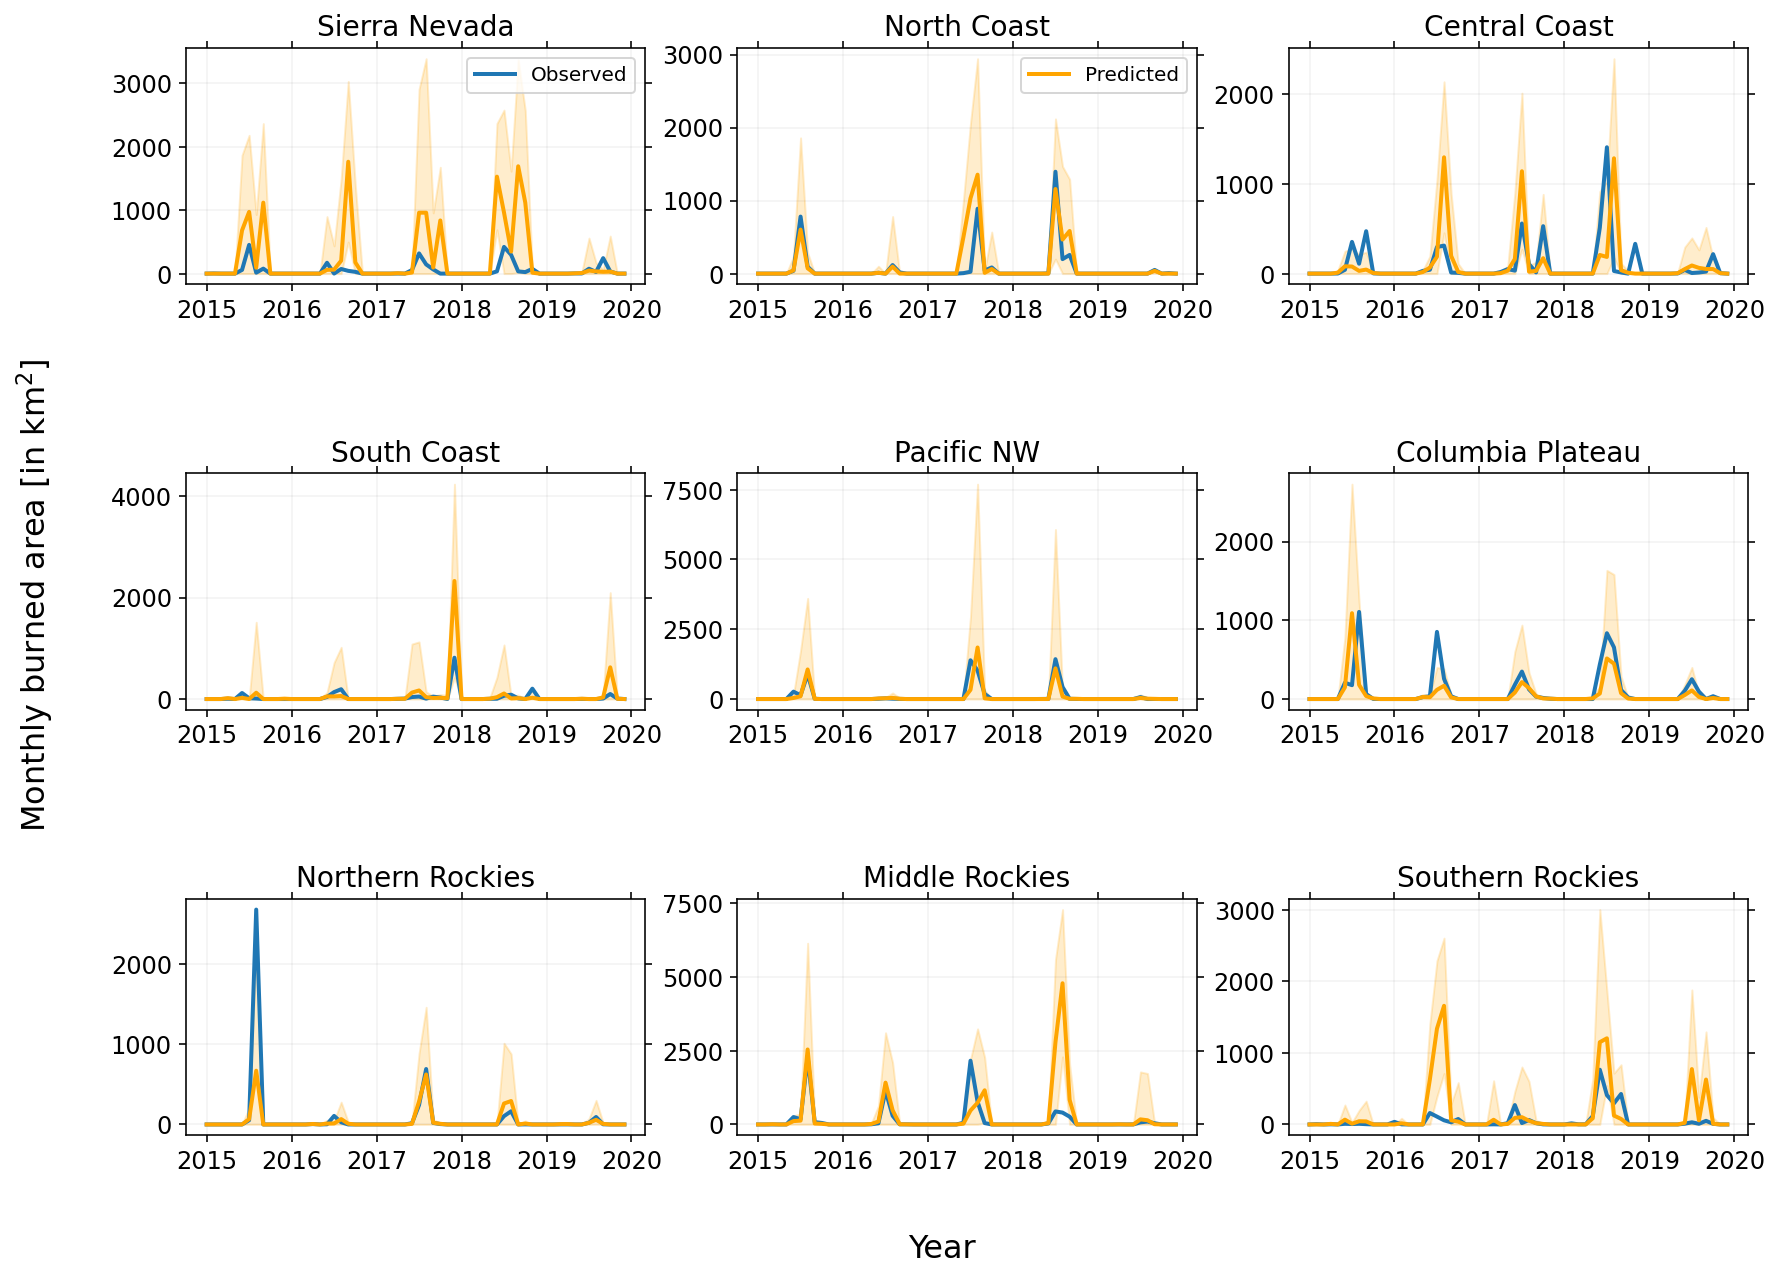

In [53]:
ind_grid_1= [[1, 2, 3], [4, 5, 6], [7, 8, 9]]
ind_grid_2= [[10, 11, 12], [13, 14, 15], [16, 17, 18]]

fig, ax= plt.subplots(3, 3, figsize=(14, 10))
#plt.suptitle(r'Monthly fire size', fontsize= 18);
fig.text(0.04, 0.5, r'Monthly burned area [in ${\rm km}^2$]', va='center', rotation='vertical', fontsize= 16);
fig.text(0.5, 0.04, r'Year', ha='center', fontsize= 16)

for i in range(3):
    for j in range(3):
        regindx= ind_grid_1[i][j]
        if i+j == 0:
            ax[i, j].plot(month_arr, mon_burned_area(fire_file, regindx)[372:], lw= 2, label= 'Observed');
            ax[i, j].legend(loc='upper right', frameon= True);
        else:
            ax[i, j].plot(month_arr, mon_burned_area(fire_file, regindx)[372:], lw= 2);
        if (i==0)&(j==1):
            ax[i, j].plot(month_arr, reg_ml_size_groups.get_group(regindx)['mean_size'], color= 'orange', lw= 2, label= 'Predicted');
            ax[i, j].legend(loc='upper right', frameon= True);
        else:
            ax[i, j].plot(month_arr, reg_ml_size_groups.get_group(regindx)['mean_size'], color= 'orange', lw= 2);
        ax[i, j].fill_between(month_arr, reg_ml_size_groups.get_group(regindx)['high_1sig_size'], reg_ml_size_groups.get_group(regindx)['low_1sig_size'], \
                                                                                                                             color= 'orange', alpha=0.2);
        ax[i, j].set_title(reg_name[regindx], fontsize= 14);
        
        ax[i, j].set_xticks((year_arr - 2015)*12);
        ax[i, j].set_xticklabels(year_arr)
        #ax[i, j].set_yscale('log')
            
        fig.subplots_adjust(hspace= 0.8)
        #fig.minorticks_on()
        ax[i, j].tick_params(labeltop=False, top=True, labelright=False, right=True, which='both', labelsize= 12);
        ax[i, j].grid(b=True, which='major', color='black', alpha=0.05, linestyle='-');
        ax[i, j].grid(b=True, which='minor', color='black', alpha=0.01, linestyle='-');
        

#plt.savefig('../plots/ml_eff_const_fire_size_1_24km.pdf', bbox_inches='tight');